# MACHINE LEARNING FORECAST
## NIXTLA 

In [5]:
%pip install nixtla
%pip install statsforecast
%pip install mlforecast

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import re
import pandas as pd
from pathlib import Path
from typing import Dict, Any
# NIXTLA
from nixtla import NixtlaClient
# STATSFORECAST
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.utils import AirPassengersDF
# MLFORECAST
from mlforecast.utils import generate_daily_series
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences
from utilsforecast.plotting import plot_series


c:\Users\AlejandroLaderasImpe\Documents\InterForecast\.venv\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
c:\Users\AlejandroLaderasImpe\Documents\InterForecast\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# --- Patrones de nombres: df_<Cliente>_<ABBR>(_mH|_wH)? y df_ALL_<ABBR>(_mH|_wH)?
_ABBRS = ('ITS', 'LTS', 'STS', 'ETS')
_PATTERNS = [
    re.compile(rf"^df_[A-Za-z0-9]+_({'|'.join(_ABBRS)})_(m|w)\d+$"),
    re.compile(rf"^df_[A-Za-z0-9]+_({'|'.join(_ABBRS)})$"),
    re.compile(rf"^df_ALL_({'|'.join(_ABBRS)})_(m|w)\d+$"),
    re.compile(rf"^df_ALL_({'|'.join(_ABBRS)})$"),
]

def _is_target_name(name: str) -> bool:
    return any(p.match(name) for p in _PATTERNS)

def _coerce_basic_types(df: pd.DataFrame) -> pd.DataFrame:
    """Asegura: unique_id -> object, ds -> datetime64[ns], y -> float64."""
    out = df.copy()
    if 'unique_id' in out.columns:
        out['unique_id'] = out['unique_id'].astype('object')
    if 'ds' in out.columns:
        out['ds'] = pd.to_datetime(out['ds'], errors='coerce')
    if 'y' in out.columns:
        # Normalmente, si exportaste con ExcelWriter, 'y' ya es numérica;
        # esto es suficiente. Dejamos un coerción defensiva por si algún .xlsx antiguo
        # traía 'y' como texto:
        out['y'] = pd.to_numeric(out['y'], errors='coerce').astype('float64')
    return out

def load_splits_from_xlsx(
    source_dir: str | Path,
    *,
    into_globals: bool = False,
    coerce_types: bool = True,
    drop_extra_cols: bool = True,   # <- NUEVO: descarta cualquier columna extra
    order_base_cols: bool = True,   # <- NUEVO: reordena como unique_id, ds, y
    verbose: bool = True
) -> Dict[str, pd.DataFrame]:
    """
    Carga TODOS los .xlsx del directorio cuyo nombre cumpla el patrón de splits.
    - Devuelve {nombre_base_sin_ext: DataFrame}
    - Si into_globals = True, los deja accesibles como variables globales.
    - coerce_types = True garantiza dtypes correctos.
    - drop_extra_cols = True deja solo ['unique_id','ds','y'] (útil si hay ficheros antiguos).
    - order_base_cols = True ordena columnas como ['unique_id','ds','y'].
    """
    src = Path(source_dir)
    if not src.exists():
        raise FileNotFoundError(f"No existe la carpeta: {src}")

    outs: Dict[str, pd.DataFrame] = {}
    files = sorted([p for p in src.glob("*.xlsx") if _is_target_name(p.stem)])
    if verbose:
        print(f"📂 Encontrados {len(files)} .xlsx candidatos en {src}")

    for f in files:
        try:
            df = pd.read_excel(f, sheet_name="data", engine="openpyxl")
        except Exception:
            # fallback si no está la hoja 'data'
            df = pd.read_excel(f, engine="openpyxl")

        if coerce_types:
            df = _coerce_basic_types(df)

        # Reduce y ordena columnas si procede (soporta ficheros viejos)
        base = [c for c in ('unique_id', 'ds', 'y') if c in df.columns]
        if drop_extra_cols:
            df = df.loc[:, base]
        elif order_base_cols:
            # reordenar base al frente pero mantener el resto
            rest = [c for c in df.columns if c not in base]
            df = df.loc[:, base + rest]

        name = f.stem
        outs[name] = df
        if into_globals:
            globals()[name] = df
        if verbose:
            print(f"⬆️  Cargado {name} ({len(df):,} filas)")

    return outs

In [3]:
# ======================
# Ejemplo de utilización
# ======================
# Cargar y dejar disponibles como variables globales (df_Noel_STS_m6, etc.)
loaded = load_splits_from_xlsx(
    "./exports_splits",
    into_globals   = True,
    coerce_types   = True,
    drop_extra_cols= True,   # asegura solo 3 columnas si algún fichero antiguo tenía extras
    verbose        = True
)

# # O, si prefieres solo un dict y no ensuciar globals():
# loaded_dict = load_splits_from_xlsx(
#     "./exports_splits",
#     into_globals   = False,
#     coerce_types   = True,
#     drop_extra_cols= True,
#     verbose        = True
# )

📂 Encontrados 230 .xlsx candidatos en exports_splits
⬆️  Cargado df_ALL_ETS (78,822 filas)
⬆️  Cargado df_ALL_ETS_m12 (66,907 filas)
⬆️  Cargado df_ALL_ETS_m3 (78,822 filas)
⬆️  Cargado df_ALL_ETS_m6 (74,249 filas)
⬆️  Cargado df_ALL_ITS (201,145 filas)
⬆️  Cargado df_ALL_ITS_m12 (176,660 filas)
⬆️  Cargado df_ALL_ITS_m3 (201,145 filas)
⬆️  Cargado df_ALL_ITS_m6 (191,066 filas)
⬆️  Cargado df_ALL_LTS (156,607 filas)
⬆️  Cargado df_ALL_LTS_m12 (125,997 filas)
⬆️  Cargado df_ALL_LTS_m3 (156,607 filas)
⬆️  Cargado df_ALL_LTS_m6 (146,995 filas)
⬆️  Cargado df_ALL_STS (212,173 filas)
⬆️  Cargado df_ALL_STS_m12 (189,387 filas)
⬆️  Cargado df_ALL_STS_m3 (212,173 filas)
⬆️  Cargado df_ALL_STS_m6 (203,369 filas)
⬆️  Cargado df_Amc_ETS (2,196 filas)
⬆️  Cargado df_Amc_ETS_m12 (2,196 filas)
⬆️  Cargado df_Amc_ETS_m3 (2,196 filas)
⬆️  Cargado df_Amc_ETS_m6 (2,196 filas)
⬆️  Cargado df_Amc_ITS (64,999 filas)
⬆️  Cargado df_Amc_ITS_m12 (64,999 filas)
⬆️  Cargado df_Amc_ITS_m3 (64,999 filas)
⬆️  Carg

# NIXTLA - TimeGPT

Import the Nixtla client and instantiate it with your API key:

In [4]:
# Nixtla Client Setup
nixtla_client = NixtlaClient(api_key = 'nixak-vDWguUlBh5MiClqOSkUvVQhtbJPYi0p6yIPvjC2fqq6zTuk168fiFPp7CLfi5QCFv0xXkQYmbO5FlSqP')

In [5]:
# Validate API Key
nixtla_client.validate_api_key()

INFO:nixtla.nixtla_client:Happy Forecasting! :)


True

## Start making forecasts!

In [6]:
# Load AirPassengers Data
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.head()

timestamp  value
0  1949-01-01    112
1  1949-02-01    118
2  1949-03-01    132
3  1949-04-01    129
4  1949-05-01    121

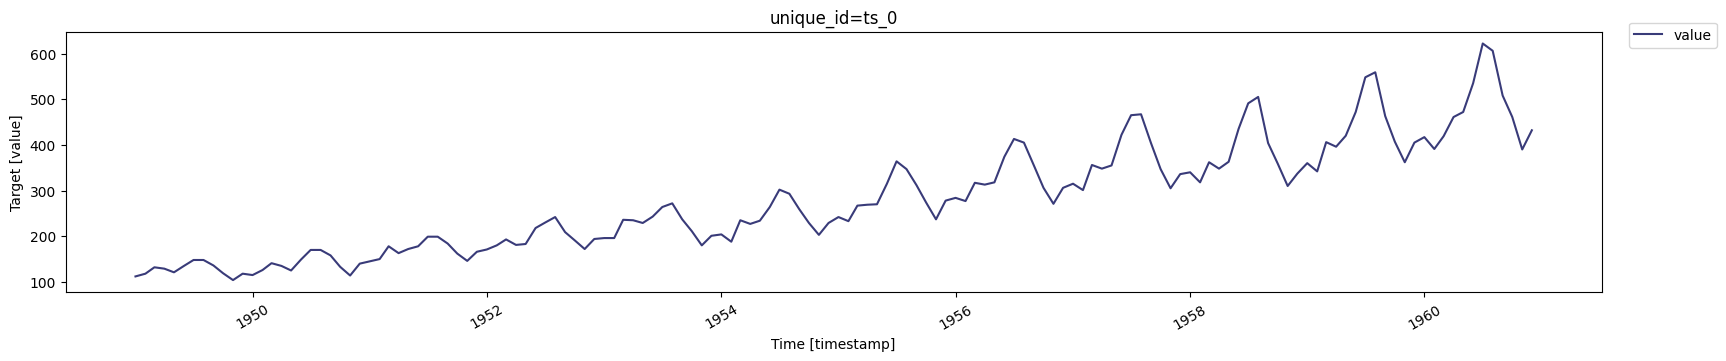

In [7]:
# Plot AirPassengers Data
nixtla_client.plot(df, time_col = 'timestamp', target_col = 'value')

### Short-Term Forecasting Example

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


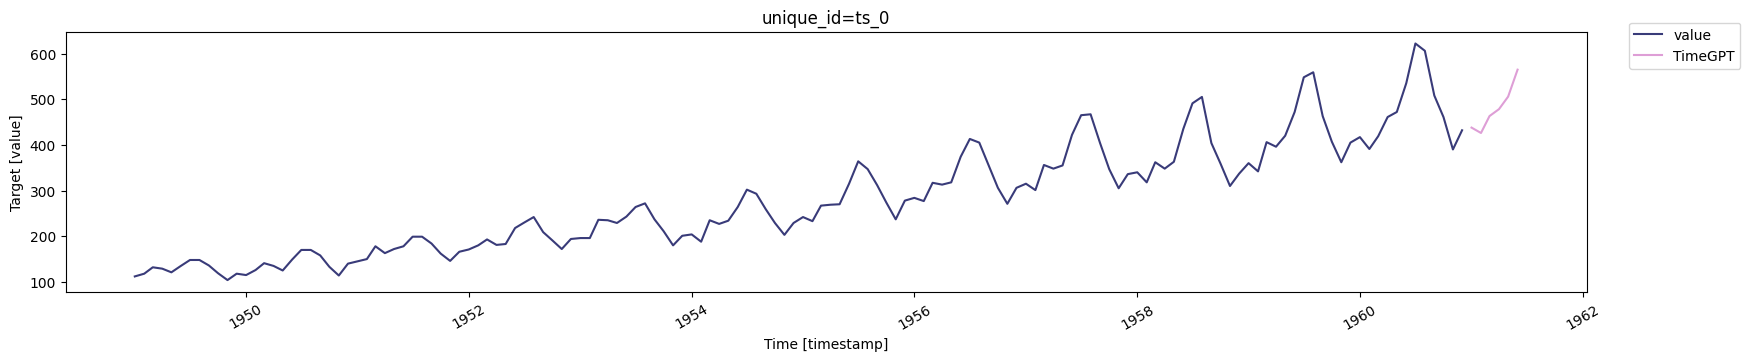

In [8]:
# Forecast 6 Months
timegpt_fcst_df = nixtla_client.forecast(
    df = df,
    h = 6,
    freq = 'MS',
    time_col = 'timestamp',
    target_col = 'value'
)
nixtla_client.plot(
    df,
    timegpt_fcst_df,
    time_col = 'timestamp',
    target_col = 'value'
)

### Long-Term Forecasting Example

In [9]:
# Forecast the next 12 months using the SDK's forecast method:
# Forecast 12 Months
timegpt_fcst_df = nixtla_client.forecast(
    df = df,
    h = 12,
    freq = 'MS',
    time_col = 'timestamp',
    target_col = 'value'
)
timegpt_fcst_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


timestamp    TimeGPT
0 1961-01-01  437.83792
1 1961-02-01  426.06270
2 1961-03-01  463.11655
3 1961-04-01  478.24450
4 1961-05-01  505.64648

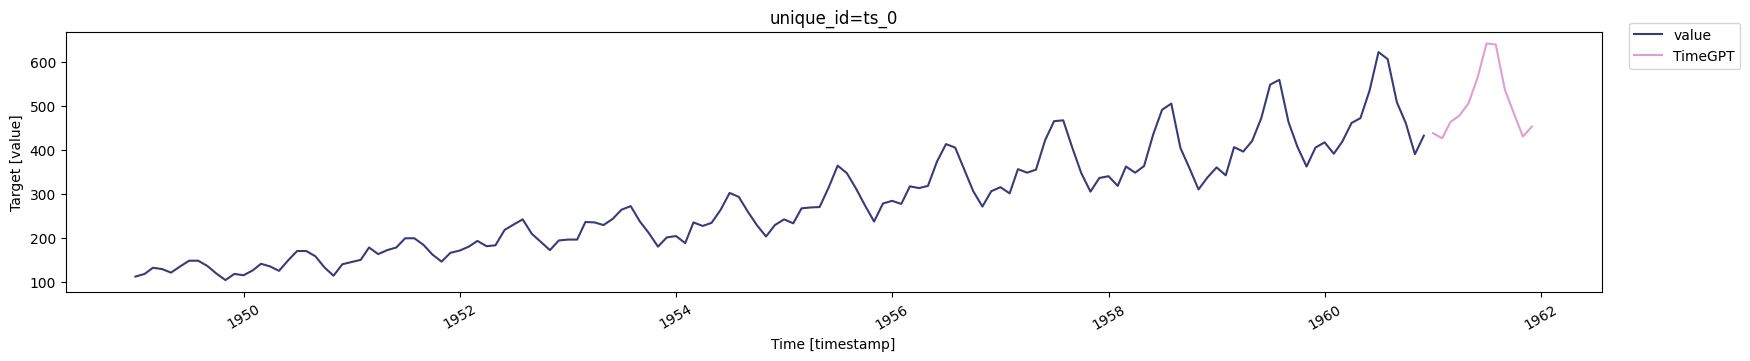

In [10]:
# Display the forecast:
nixtla_client.plot(
    df,
    timegpt_fcst_df,
    time_col = 'timestamp',
    target_col = 'value')

You may also generate forecasts for longer horizons with the `timegpt-1-long-horizon` model. For example, 36 months ahead:

In [11]:
# Forecast 36 Months Long Horizon
timegpt_fcst_df = nixtla_client.forecast(
    df = df,
    h = 36,
    freq = 'MS',
    time_col = 'timestamp',
    target_col = 'value',
    model = 'timegpt-1-long-horizon'
)
timegpt_fcst_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


timestamp    TimeGPT
0 1961-01-01  436.84340
1 1961-02-01  419.35153
2 1961-03-01  458.94315
3 1961-04-01  477.87607
4 1961-05-01  505.65692

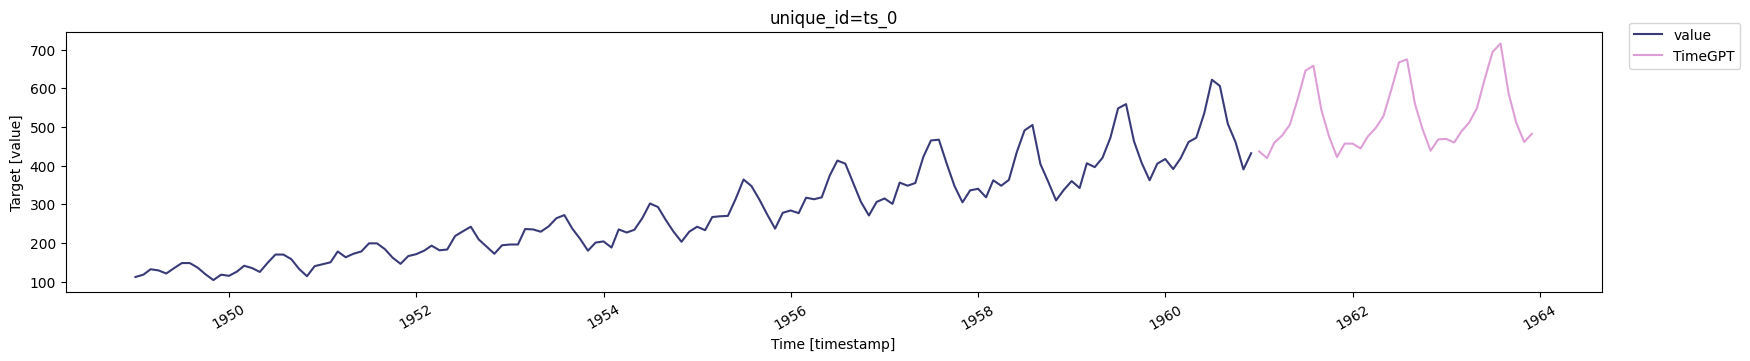

In [12]:
# Plot 36 Month Forecast
nixtla_client.plot(
    df,
    timegpt_fcst_df,
    time_col = 'timestamp',
    target_col = 'value'
)

# NIXTLA - StatsForecast

StatsForecast offers a collection of popular univariate time series forecasting models optimized for high performance and scalability.

## Quick Start

`StatsForecast` follows the sklearn model API. For this minimal example, you will create an instance of the StatsForecast class and then call its `fit` and `predict` methods. We recommended this option if speed is not paramount and you want to explore the fitted values and parameters.

The input to StatsForecast is always a data frame in long format with three columns: `unique_ds`, `ds` and `y`.

- The `unique_id` (string, int or category) representes and identifier for the series.
- The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.
- The `y` (numeric) represents the measurement we wish to forecast.

As an example let's look at the US Air Passengers dataset. This time series consists of monthly totals of a US airline passengers from 1949 to 1960.

In [13]:
# First, we'll import the data:
df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/air-passengers.csv', parse_dates=['ds'])
df.head()

unique_id         ds    y
0  AirPassengers 1949-01-01  112
1  AirPassengers 1949-02-01  118
2  AirPassengers 1949-03-01  132
3  AirPassengers 1949-04-01  129
4  AirPassengers 1949-05-01  121

We fit the model by instantiating a new StatsForecast object with its two required parameters: https://nixtlaverse.nixtla.io/statsforecast/src/core/models.html models: a list of models.
Select the models you want from models and import them. For this example, we will use a AutoARIMA model.
We set `season_lenght` to 12 because we expect seasonal effects every 12 months.

 - `freq`: a string indicating the frequency of the data.

Any setting are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [14]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.models import AutoETS

In [15]:
sf = StatsForecast(
    models = [AutoARIMA(season_length = 12),
              AutoETS(season_length = 12)],
    freq = 'MS',
)

sf.fit(df)

StatsForecast(models=[AutoARIMA,AutoETS])

The `predict` method takes two arguments: forecast the next `h` (for horizon) and `level`.

- `h` (int): represents the forecast h steps into the future. In this case, 12 months ahead.
- `level` (list of floats): this optional parameter is used for probabilistic forecasting. See the `level` (or confidence percentile) of your prediction interval. For example, `level = [90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainly intervals.

In [16]:
forecast_df = sf.predict(h = 12, level = [90])
forecast_df.tail()

unique_id         ds   AutoARIMA  AutoARIMA-lo-90  AutoARIMA-hi-90  \
7   AirPassengers 1961-08-01  633.236389       590.009033       676.463745   
8   AirPassengers 1961-09-01  535.236389       489.558899       580.913940   
9   AirPassengers 1961-10-01  488.236389       440.233795       536.239014   
10  AirPassengers 1961-11-01  417.236389       367.016205       467.456604   
11  AirPassengers 1961-12-01  459.236389       406.892456       511.580322   

       AutoETS  AutoETS-lo-90  AutoETS-hi-90  
7   594.768250     539.850525     649.686035  
8   513.703186     456.658966     570.747437  
9   448.222626     389.610657     506.834625  
10  390.316254     330.542480     450.090057  
11  435.738007     374.546692     496.929321

You can plot the forecast by calling the `StatsForecast.plot` method and passing in your forecast dataframe.

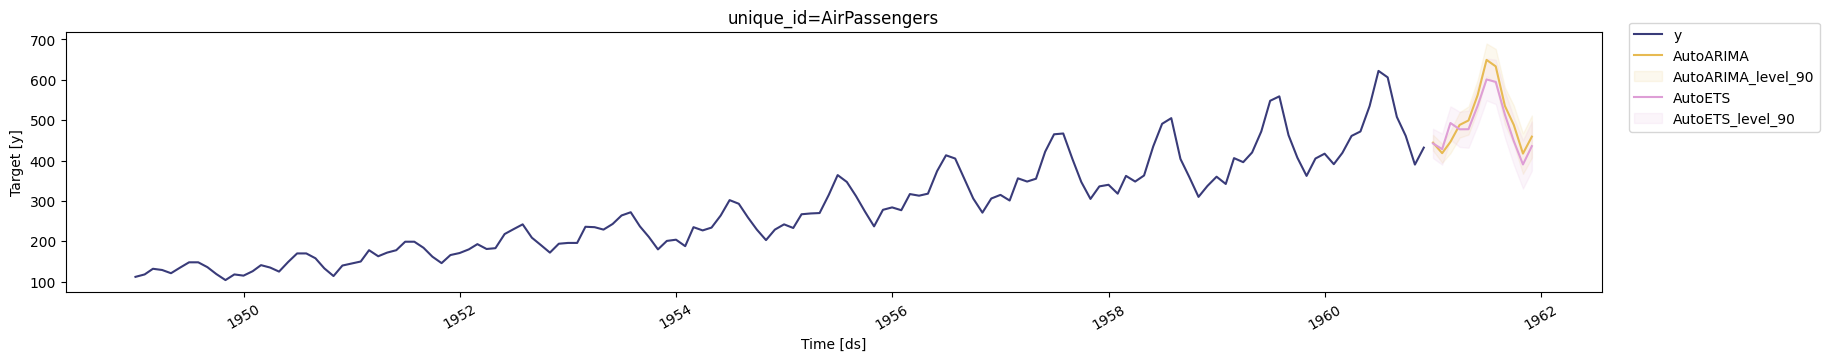

In [17]:
sf.plot(df, forecast_df, level = [90])

## Next Steps

- Build and end-to-end forecasting pipeline following best prectices in End to End Walkthrough.
- Forecast millions of series in a scalable cluster in the cloud using Spark and Nixtla.
- Detect anomalies in your pas observations.

# End to End Walkthrough

Model training, evaluation and selection for multiple time series

During this guid you will gain familiary the core StatsForecast class and som relevant methods like `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation`.

We will use a classical benchmarking dataset from the M4 competition. The dataset includes time series from different domains like finance, economy and sales. In this example, we will use a subset of the Hourly dataset.

We will model each time series individually. Forecasting at this level is also known as local forecasting. Therefore, you will train a series of models for every unique series and then select the best one. StatsForecas focuses on speed, simplicity, and scalability, which makes it ideal for this task.

## Outline:

1. Install packages.
2. Read the data.
3. Explore the data.
4. Train many models for every unique combination of time series.
5. Evaluate the model's performance using cross-validation.
6. Select the best model for every unique time series.

## Read the data

We will use pandas to read the M4 Hourly data set stored in a parquet file for efficiency. You can use ordinary pandas operations to read your data in other formats likes .csv.

The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

- The unique_id (string, int or category) represents an identifier for the series.
- The ds (datestamp or int) column should be either an integer indexing time or a datestampe ideally like YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.
- The y (numeric) represents the measurement we wish to forecast. The target column needs to be renamed to y if it has a different column name.

In [18]:
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
Y_df.head()

unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0

This dataset contains 414 unique series with 900 observations on average. For this example and reproducibility's sake, we will select only 10 unique IDs and keep only the last week. Depending on your processing infraestructure feel free to select more or less series.

In [19]:
uids = Y_df['unique_id'].unique()[:10] # Select 10 ids to make the example faster
Y_df = Y_df.query('unique_id in @uids')
Y_df = Y_df.groupby('unique_id').tail(7 * 24) #Select last 7 days of data to make example faster

## Explore Data with the plot method

Plot some series using the `plot` method from the `StatsForecast` class. This method prints 8 random series from the dataset and is useful for basic EDA.

The `StatsForecast.plot` method uses Plotly as a default engine. You can change to MatPlotLib by setting `engine="matplotlib"`.

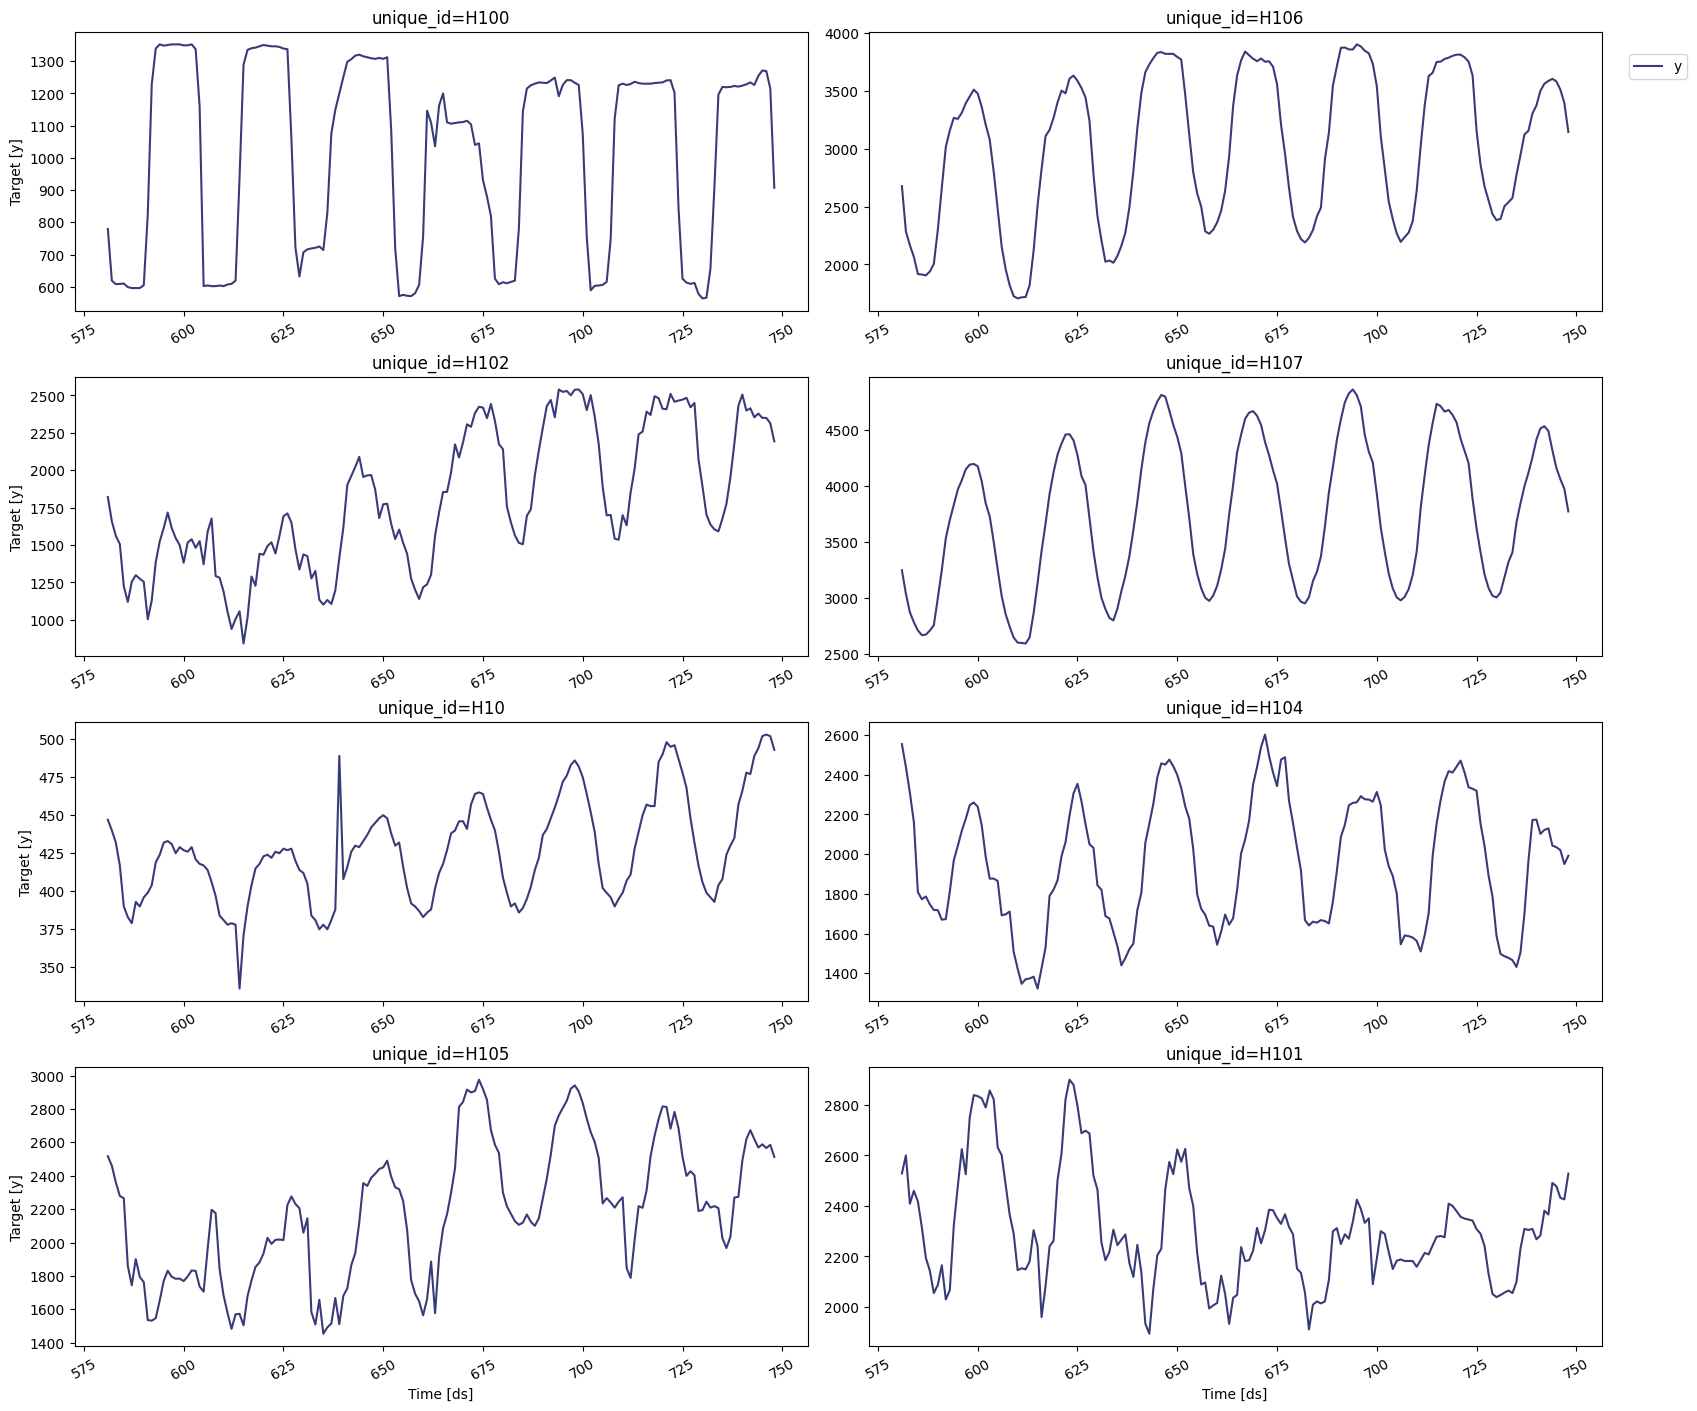

In [20]:
StatsForecast.plot(Y_df)

## Train multiple models for many series

StatsForecast can train many models on many time series efficiently.

Start by importing and instantiating the desired models. StatsForecast offers a wide variety of models gropuped in the following categories:

- **Auto Forecast**: Automatic forecasting tools search for the best parameters and select the best possible model for a series of time series. These tools are useful for large collections of univariate time series. Includes automatic versions of: ARIMA, ETS, Theta, CES.

- **Exponential Smoothing**: Uses a weighted average of all past observations where the weights decreas exponentially into the past. Suitable for data with no clear trend or seasonality. Examples: SES, Holt's Winters, SSO.

- **Benchmark models**: Classical models for establishing baselines. Examples: Mean, Naive, Random Walk.

- **Intermittent of Sparse models**: Suited for series with very few non-zero observations. Examples: CROSTON, ADIDA, IMAPA.

- **Multiple Seasonalities**: Suited for signals with more than one clear seasonality. Useful for low-frequency data like electricity and logs. Examples: MSTL.

- **Theta Models**: Fit two theta lines to a deseasonalized time seres, using different techniques to obtain and combine the two theta lines to produce the final forecasts. Examples: Theta, DynamicTheta.

Here you can check the complet list of models (https://nixtlaverse.nixtla.io/statsforecast/src/core/models.html)

For this example we will use:

- AutoARIMA: Automatically selects the best ARIMA (AutoRegressive Integrated Moving Average) model using an information criterion. Ref: AutoARIMA.
- HoltWinters: triple exponential smoothing, Holt-Winters’ method is an extension of exponential smoothing for series that contain both trend and seasonality. Ref: HoltWinters
- SeasonalNaive: Memory Efficient Seasonal Naive predictions. Ref: SeasonalNaive
- HistoricAverage: arthimetic mean. Ref: HistoricAverage.
- DynamicOptimizedTheta: The theta family of models has been shown to perform well in various datasets such as M3. Models the deseasonalized time series. Ref: DynamicOptimizedTheta.

Import and instantiate the models. Setting the season_length argument is sometimes tricky. This article on Seasonal periods) by the master, Rob Hyndmann, can be useful.

In [21]:
from statsforecast.models import(
    HoltWinters,
    CrostonClassic as Croston,
    HistoricAverage, 
    DynamicOptimizedTheta as DOT,
    SeasonalNaive)

In [22]:
# Create a list of models and instantiation parameters
models = [
    HoltWinters(),
    Croston(),
    SeasonalNaive(season_length = 24),
    HistoricAverage(),
    DOT(season_length = 24)
]

We fit the models by instantiating a new StatsForecast object with the following parameters:

- models: a list of models. Select the models you want from models and import them.
- freq: a string indicating the frequency of the data.
- n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.
- fallback_model: a model to be used of a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [23]:
# Instantiate StatsForecast class as sf
sf = StatsForecast(
    models = models,
    freq = 1,
    fallback_model = SeasonalNaive(season_length = 7),
    n_jobs = -1,
)

**Note** StatsForecast achieves its blazing speed using JIT compiling through Numba. The first time you call the statsforecast class, the fit method should take around 5 seconds. The second time -once Numba compiled your settings- it should take less than 0.2s.

The forecast method takes two arguments: forecasts next h (horizon) and level.

- h (int): represents the forecast h steps into the future. In this case, 12 months ahead.
- level (list of floats): this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, level=[90] means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min. (If you want to speed things up to a couple of seconds, remove the AutoModels like ARIMA and Theta)

**Note** The forecast method is compatible with distributed clusters, so it does not store any model parameters. If you want to store parameters for every model you can use the fit and predict methods. However, those methods are not defined for distrubed engines like Spark, Ray or Dask.

In [24]:
forecasts_df = sf.forecast(df = Y_df, h = 48, level = [90])
forecasts_df.head()

unique_id   ds  HoltWinters  HoltWinters-lo-90  HoltWinters-hi-90  \
0        H1  749        829.0         422.549268        1235.450732   
1        H1  750        807.0         400.549268        1213.450732   
2        H1  751        785.0         378.549268        1191.450732   
3        H1  752        756.0         349.549268        1162.450732   
4        H1  753        719.0         312.549268        1125.450732   

   CrostonClassic  CrostonClassic-lo-90  CrostonClassic-hi-90  SeasonalNaive  \
0           829.0            422.549268           1235.450732          635.0   
1           807.0            400.549268           1213.450732          572.0   
2           785.0            378.549268           1191.450732          532.0   
3           756.0            349.549268           1162.450732          493.0   
4           719.0            312.549268           1125.450732          477.0   

   SeasonalNaive-lo-90  SeasonalNaive-hi-90  HistoricAverage  \
0           566.036734           703.963266       660.982143   
1           503.036734           640.963266       660.982143   
2           463.036734           600.963266       660.982143   
3           424.036734           561.963266       660.982143   
4           408.036734           545.963266       660.982143   

   HistoricAverage-lo-90  HistoricAverage-hi-90  DynamicOptimizedTheta  \
0             398.037761             923.926524             592.701851   
1             398.037761             923.926524             525.589117   
2             398.037761             923.926524             489.251814   
3             398.037761             923.926524             456.195032   
4             398.037761             923.926524             436.290514   

   DynamicOptimizedTheta-lo-90  DynamicOptimizedTheta-hi-90  
0                   577.677300                   611.652642  
1                   505.449706                   546.621821  
2                   462.072830                   512.424107  
3                   430.554311                   478.260966  
4                   411.051209                   461.815996

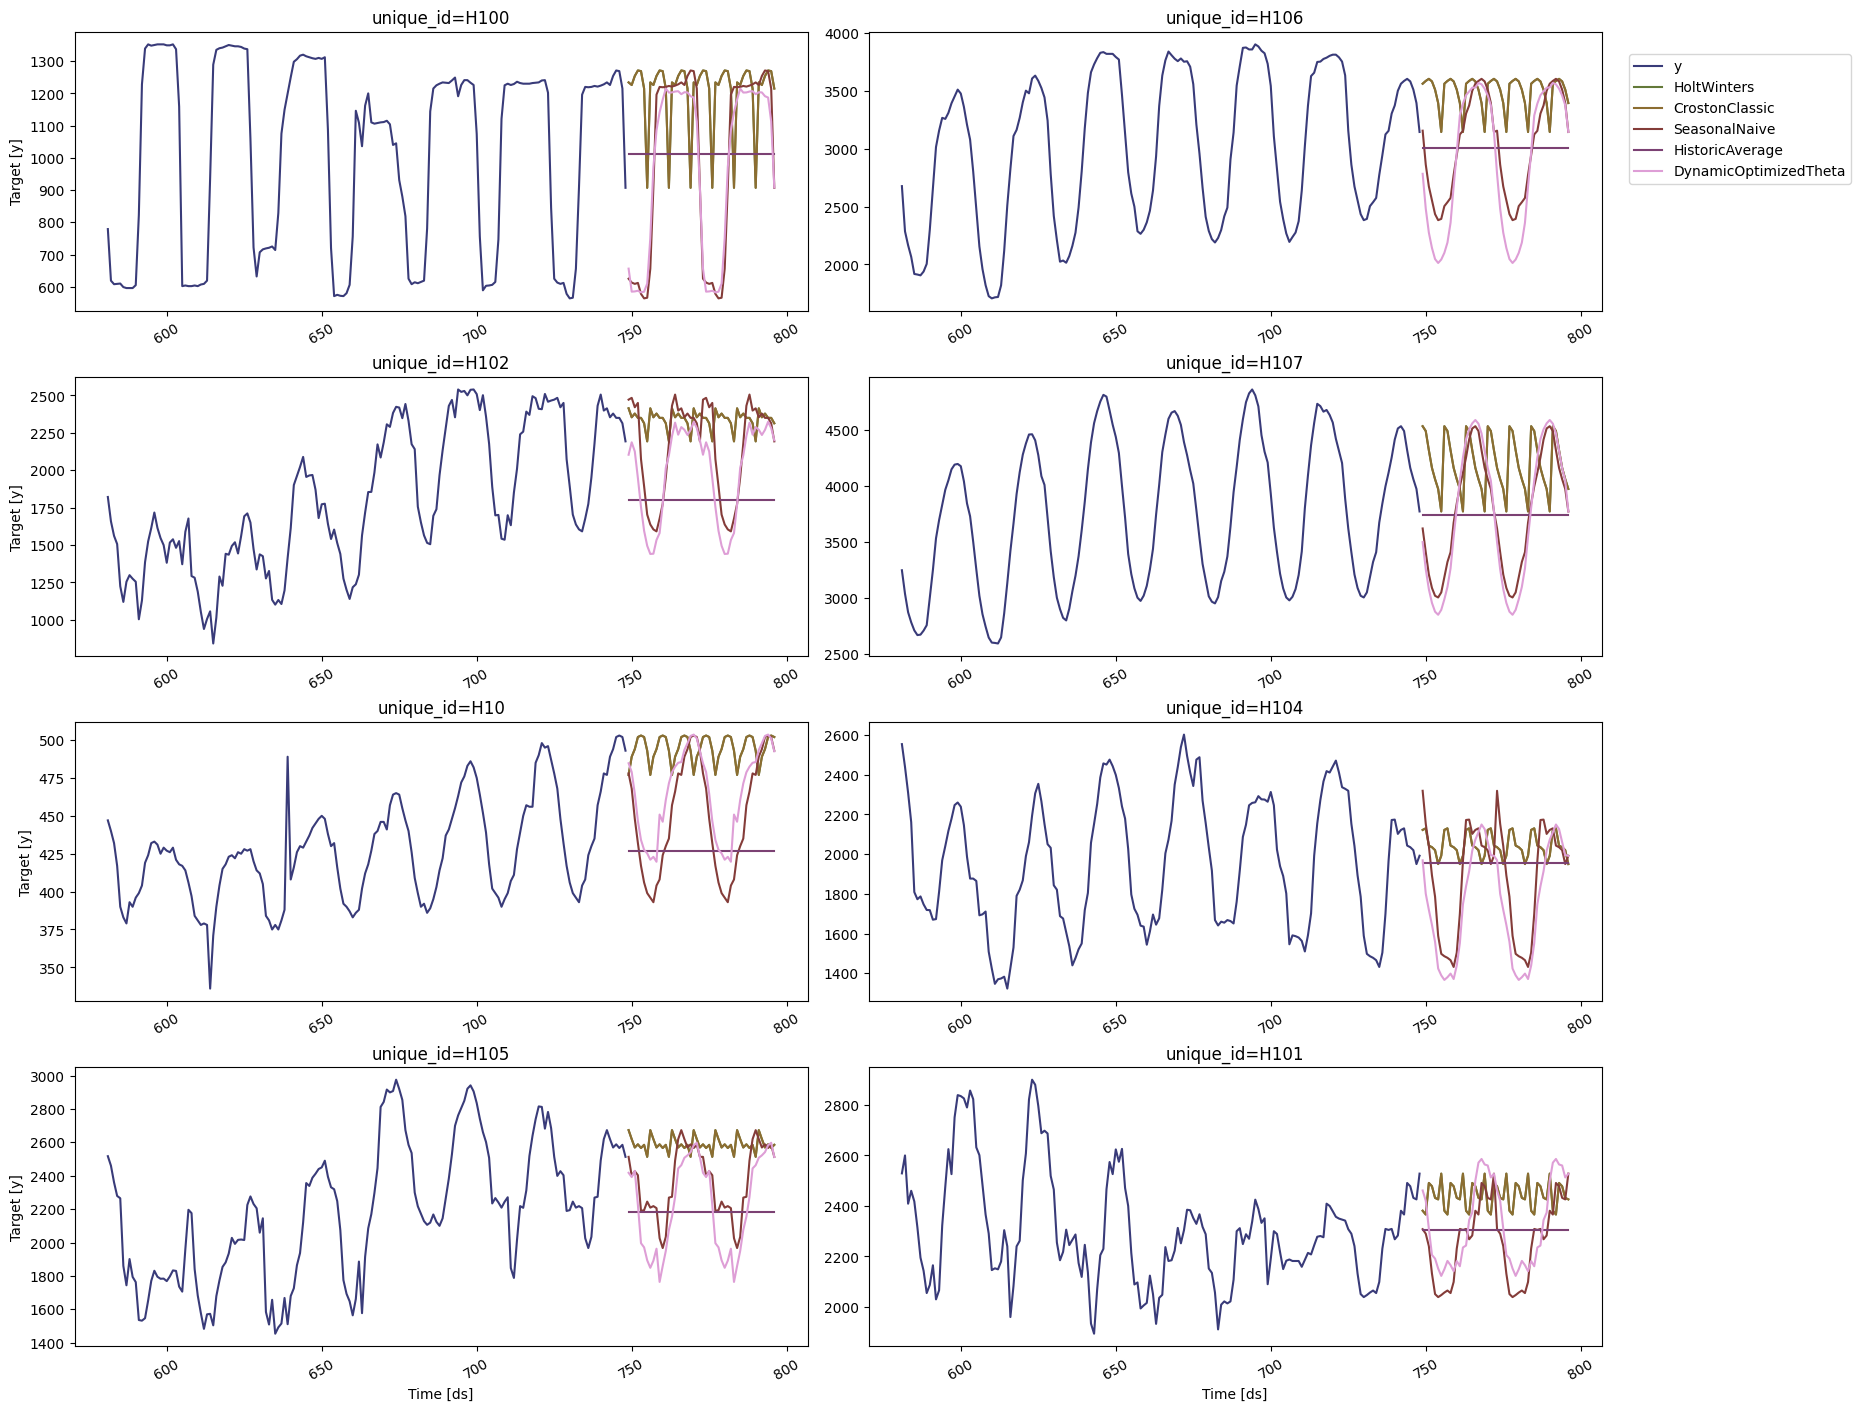

In [26]:
# Plot the results of 8 random series using the StatsForecast.plot method.
sf.plot(Y_df, forecasts_df)

The `StatsForecast.plot` allows for further customization. For example, plot the results od the different models and unique ids.

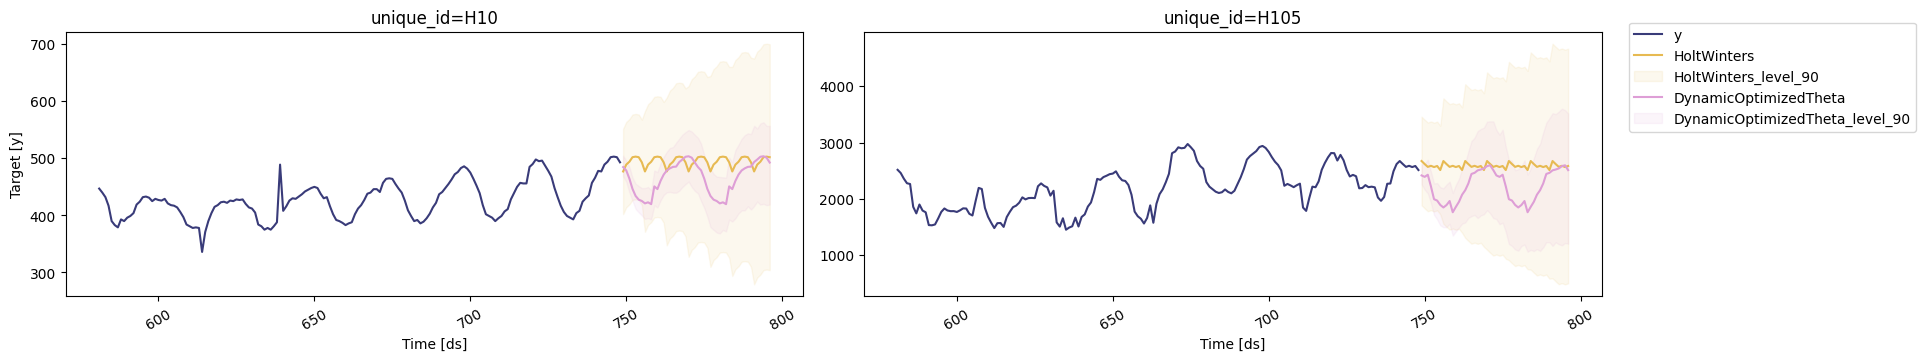

In [25]:
# Plot to unique_ids and some selected models
sf.plot(Y_df, forecasts_df, models = ['HoltWinters', 'DynamicOptimizedTheta'], unique_ids = ['H10', 'H105'], level = [90])

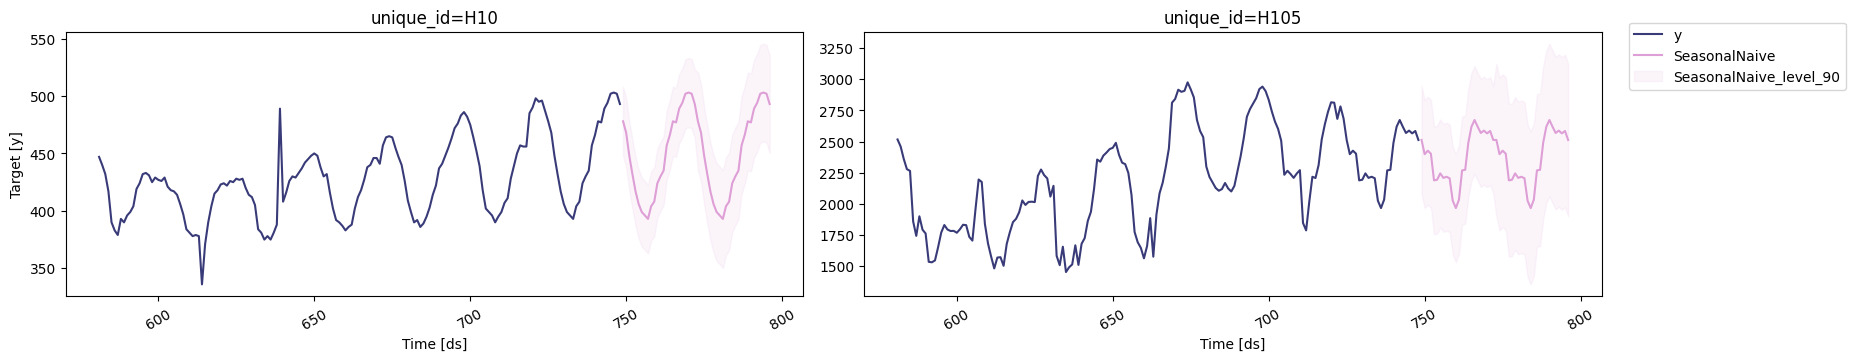

In [26]:
# Explore other models
sf.plot(Y_df, forecasts_df, models = ['SeasonalNaive'], unique_ids = ['H10', 'H105'], level = [90])

## Evaluate the model's performance

In previous steps, we've taken our historical data to predict the future. However. to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window acroos the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model's predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.


The following graph depicts such a Cross Validation Strategy:

![alt text](image.png)

Cross-Validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 2 days (n_windows = 2), forecasting every second day (step_size = 48). Depending on your computer, this step should take around 1 min.

Tip: Setting n_windows = 1 mirrors a traditional train-test split with our historical data serving as the training set and the last 48 hours serving as the testing set.

The cross_validation method from the StatsForecast class takes the following arguments.

- df: training data frame.
- h (int): represents h steps into the futre that are being forecasted. In this case, 24 hours ahead.
- step_size (int): step size between each window. In other words: how often do you want to run the forecasting processes.
- n_windows (int): number of window used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [27]:
cv_df = sf.cross_validation(
    df = Y_df,
    h = 24,
    step_size = 24,
    n_windows = 2
)

The cv_df object is a new data frame that includes the following columns:

- `unique_id`: series identifier.
- `ds`: datestamp or temporal index.
- `cutoff`: the last datestamp or temporal index for the `n_windows`. If `n_windows = 1`, then one unique cuttoff value, if `n_windows = 2`, then two unique cutoff values.
- `y`: true value
- `"model"`: columns with the model's name and fitted value.

In [28]:
cv_df.head()

unique_id   ds  cutoff      y  HoltWinters  CrostonClassic  SeasonalNaive  \
0        H1  701     700  619.0        847.0      742.668748          691.0   
1        H1  702     700  565.0        820.0      742.668748          618.0   
2        H1  703     700  532.0        790.0      742.668748          563.0   
3        H1  704     700  495.0        784.0      742.668748          529.0   
4        H1  705     700  481.0        752.0      742.668748          504.0   

   HistoricAverage  DynamicOptimizedTheta  
0          661.675             612.767525  
1          661.675             536.846296  
2          661.675             497.824302  
3          661.675             464.723235  
4          661.675             440.972351

---
---
---

Next, we will evaluate the performance of every model for every series using common error metrics like Mean Absolute Error (MAE) or Mean Square Error (MSE) Define a utility function to evaluate different error metrics for the cross validation data frame.

First import the desire error metrics from utilsforecast.losses. Then define a utility function that takes a cross-validation data frame as a metric and returns an evaluation data frame with the average of the error metric for every unique id and fitted model and all cutoffs.

In [29]:
from utilsforecast.losses import mse

In [30]:
def evaluate_cv(df, metric):
    models = df.columns.drop(['unique_id', 'ds', 'y', 'cutoff']).tolist()
    evals = metric(df, models = models)
    evals['best_model'] = evals[models].idxmin(axis = 1)
    return evals

**Warning** You can also use Mean Average Percentage Error (MAPE), however for granular forecasts, MAPE values are extremely **hard to judge** and not useful to assess forecasting quality.

Creare the data frame with the results of the evaluation of your cross-validation data frame using a Mean Squared Error metric.

In [31]:
evaluation_df = evaluate_cv(cv_df, mse)
evaluation_df.head()

unique_id    HoltWinters  CrostonClassic  SeasonalNaive  HistoricAverage  \
0        H1   44888.020833    28038.733985    1422.666667     20927.664488   
1       H10    2812.916667     1483.483839      96.895833      1980.367543   
2      H100  121625.375000    91945.139237   12019.000000     78491.191439   
3      H101   28453.395833    16183.634340   10944.458333     18208.409800   
4      H102  232924.854167   132655.309136   12699.895833    309110.475212   

   DynamicOptimizedTheta             best_model  
0            1296.333117  DynamicOptimizedTheta  
1             379.631699          SeasonalNaive  
2           21699.646799          SeasonalNaive  
3           63698.059884          SeasonalNaive  
4           31393.070741          SeasonalNaive

Create a summary table with a model column and the number of series where that model performs best. In this case, the ARIMA and Seasonal Naive are the best models for 10 series and the Theta model should be used for two.

In [32]:
evaluation_df['best_model'].value_counts().to_frame().reset_index()

best_model  count
0          SeasonalNaive      6
1  DynamicOptimizedTheta      4

You can further explore your results by plotting the unique_ids where a specific model wins.

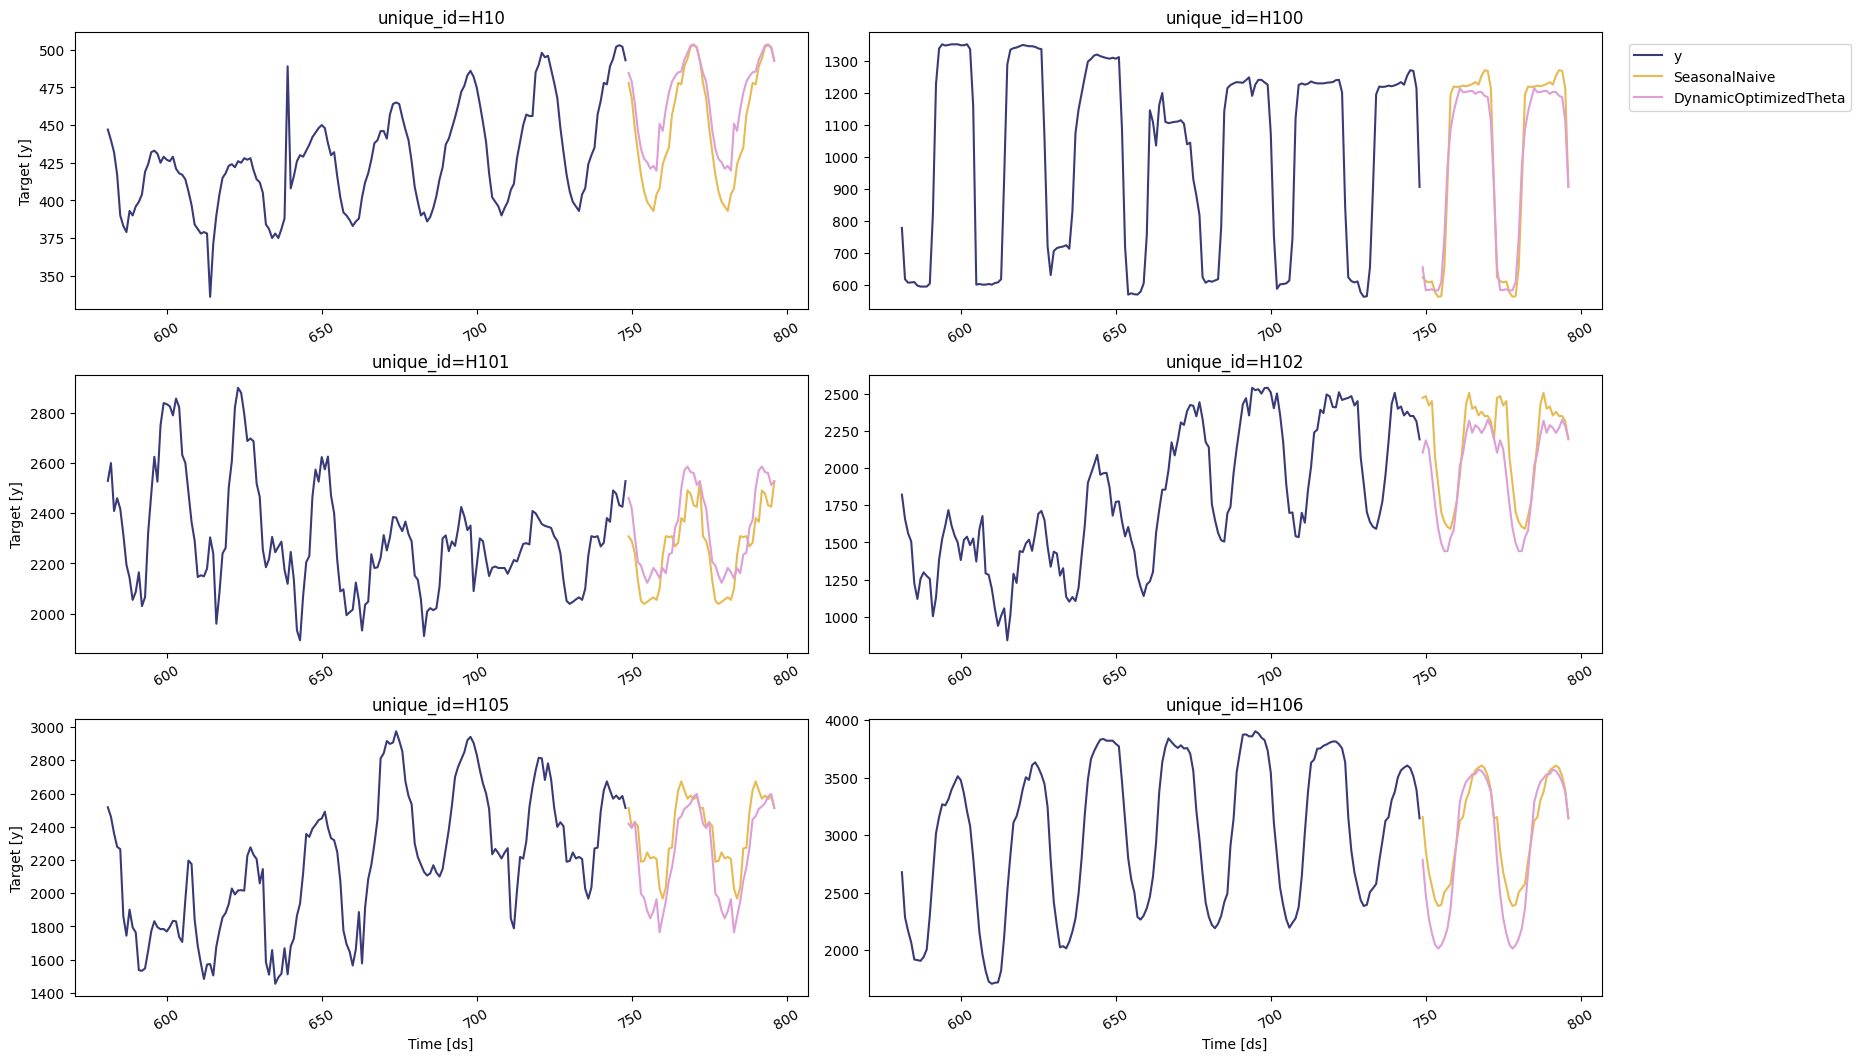

In [33]:
seasonal_ids = evaluation_df.query('best_model == "SeasonalNaive"')['unique_id']
sf.plot(Y_df, forecasts_df, unique_ids = seasonal_ids, models = ["SeasonalNaive", "DynamicOptimizedTheta"])

## Select the best model for every unique series

Define a utility function that takes your forecast's data frame with the predictions and the evaluation data frame and returns a data frame with the best possible forecast for every unique_id.

In [34]:
def get_best_model_forecast(forecasts_df, evaluation_df):
    with_best = forecasts_df.merge(evaluation_df[['unique_id', 'best_model']])
    res = with_best[['unique_id', 'ds']].copy()
    for suffix in ('', '-lo-90', '-hi-90'):
        res[f'best_model{suffix}'] = with_best.apply(lambda row: row[row['best_model'] + suffix], axis = 1)
    return res

Create your production-ready data frame with the best forecast for every unique_id.

In [35]:
prod_forecasts_df = get_best_model_forecast(forecasts_df, evaluation_df)
prod_forecasts_df.head()

unique_id   ds  best_model  best_model-lo-90  best_model-hi-90
0        H1  749  592.701851        577.677300        611.652642
1        H1  750  525.589117        505.449706        546.621821
2        H1  751  489.251814        462.072830        512.424107
3        H1  752  456.195032        430.554311        478.260966
4        H1  753  436.290514        411.051209        461.815996

Plot the results.

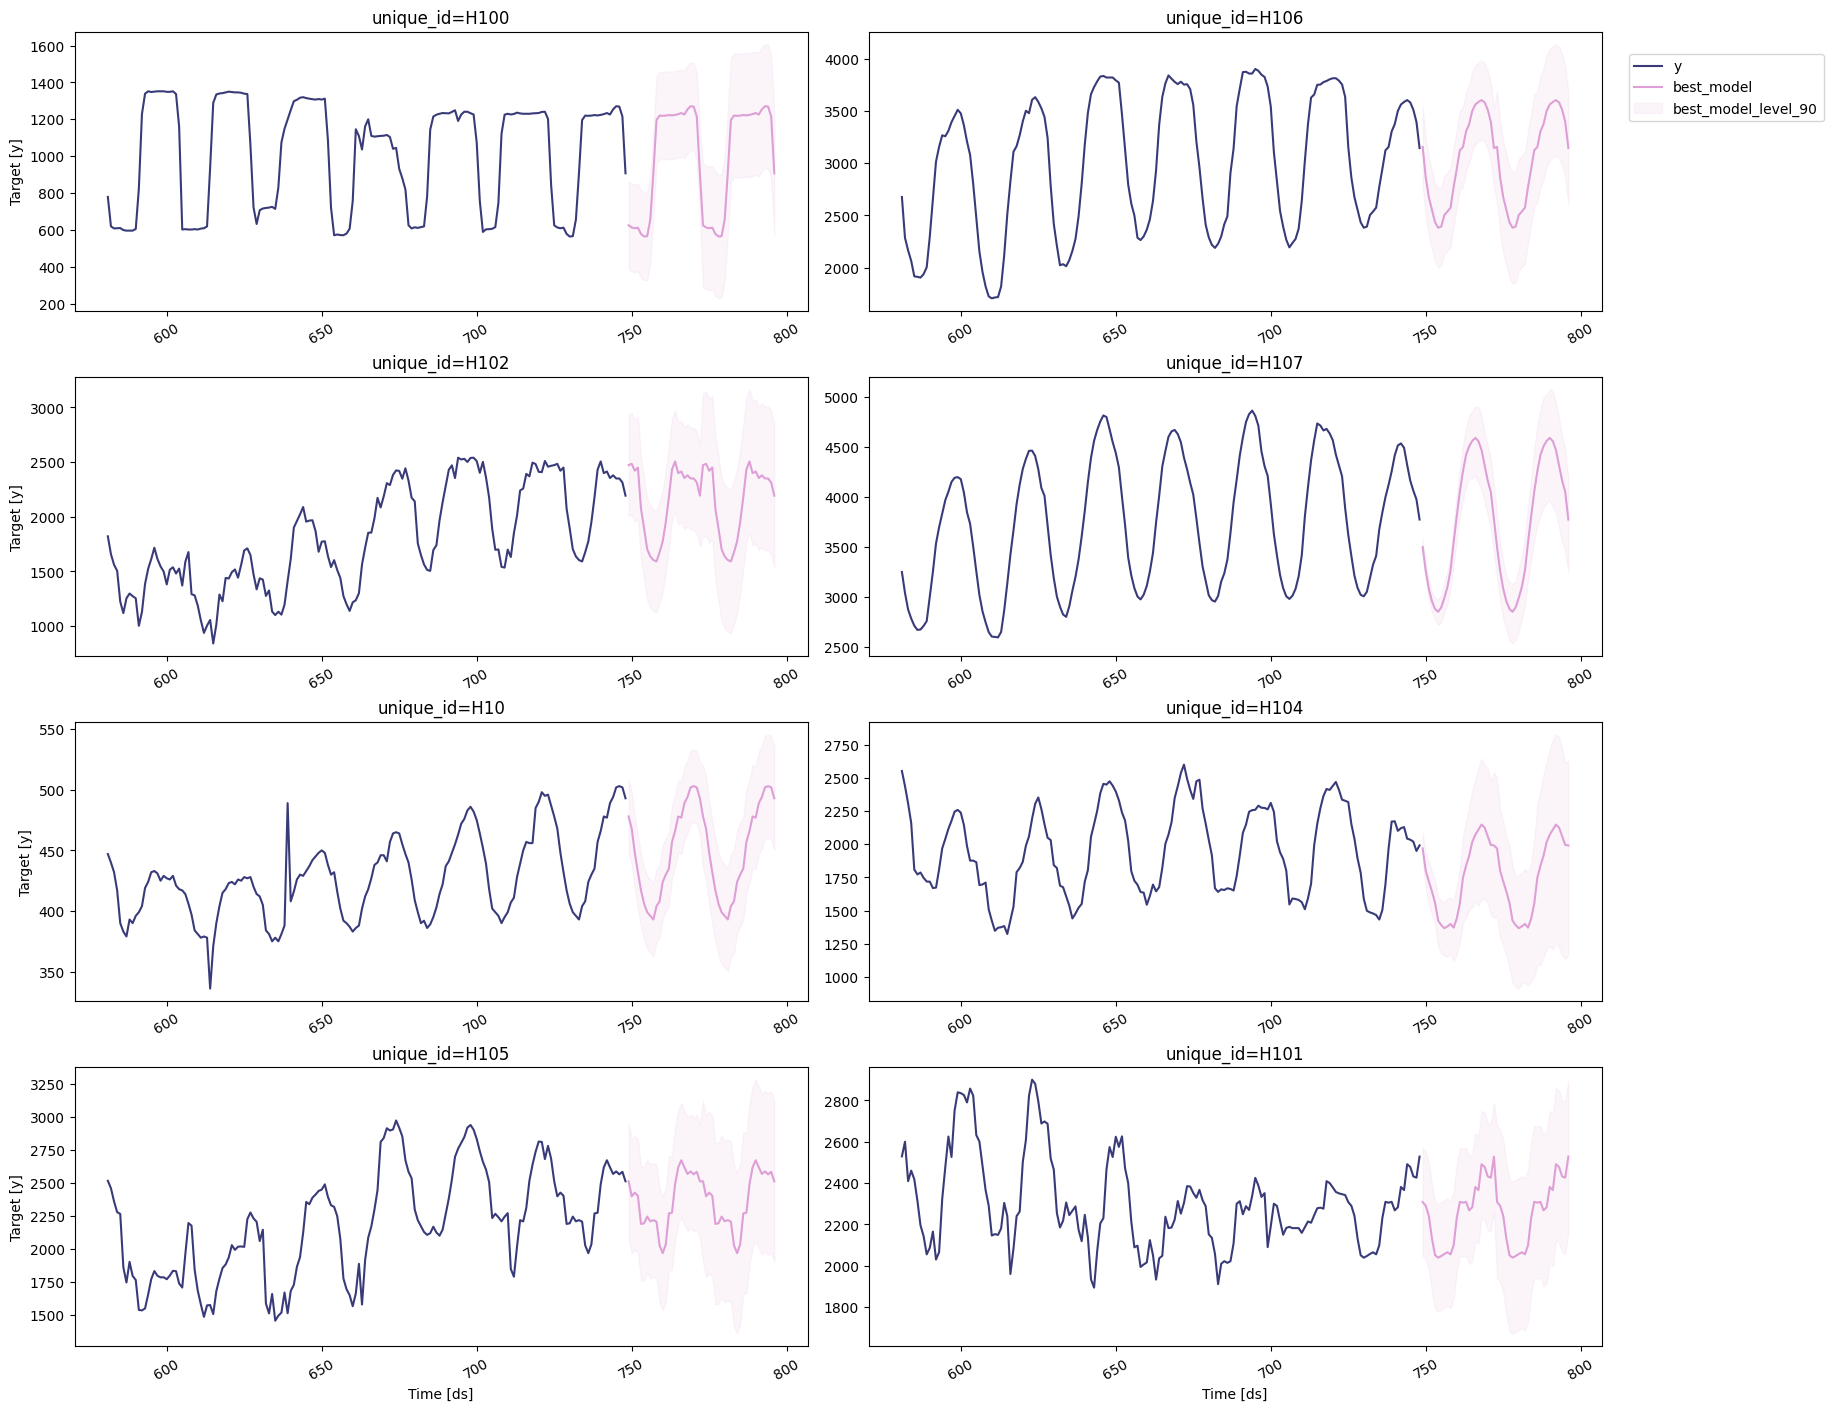

In [36]:
sf.plot(Y_df, prod_forecasts_df, level = [90])

## Anomaly Detection

In this notebook, we'll implement anomaly detection in time series data.

### Introduction

Anomaly detection is a crucial task in time series forecasting. It involves identifying unusual observations that don't follow the expected dataset patterns. Anomalies, also known as outliers, can be caused by a variety of factors, such as errors in the data collection process, sudden changes in the underlying patterns of the data, or unexpected events. They can pose problems for many forecasting models since they can distort trends, seasonal patterns, or autocorrelation estimates. As a result, anomalies can have a significat impact on the accuracy of the forecasts, and for this reaseon, it is essential to be able to identify them. Furthermore, anomaly detection has many applications across different industries, such as detecting fraud in financial data, monitoring the performance of online services, or identifying usual patterns in energy usage.

By the end of this tutorial, you'll have a good understanding of how to detect anomalies in time series data using **StatsForecast**'s probabilistic models.

**Outline**:
1. Install libraries.
2. Load and explore data.
3. Train model.
4. Recover insample forecasts and identify anomalies.

**Important**: Once an anomaly has been identified, we must decide what to do with it. For example, we could remove it or replace it with another value. The correct course of action is context-dependent and beyond this notebook’s scope. Removing an anomaly will likely improve the accuracy of the forecast, but it can also underestimate the amount of randomness in the data.

### Load and Explore the Data

For this example, we'll use the hourly dataset of the M4 Competition

In [37]:
df_total = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet')
df_total.head()

unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0

The input to StatsForecast is always a data frame in **long format** with three columns: `unique_id`, `df` and `y`.

- `unique_id`: (string, int or category) A unique identifier for the series.
- `ds`: (timestamp or int) A timestamp in format YYYY-MM-DD or YYYY-MM-DD HH:MM:SS or an integer indexing time.
- `y`: (numeric) The measurement we wish to forecast.

From this dataset, we'll select the first 8 time series to reduce the total execution time. You can select any number you want by changing the value of `n_series`.

In [38]:
n_series = 8
uids = df_total['unique_id'].unique()[:n_series]
df = df_total.query('unique_id in @uids')

We can plot these series using the `plot_series` function from the `utilsforecast` package. Ths function has multiple parameters, and the required ones to generate the plots in this notebook are explained below.

- `df`: A pandas dataframe with columns [unique_id, ds, y].
- `forecasts_df`: A pandas dataframe with columns [unique_id, ds] and models.
- `ids`: A list with the ids of the time series we want to plot.
- `level`: Prediction interval levels to plot.
- `plot_anomalies`: Whether or not to include the anomalies for each prediction interval.

In [39]:
from statsforecast import StatsForecast
from utilsforecast.plotting import plot_series

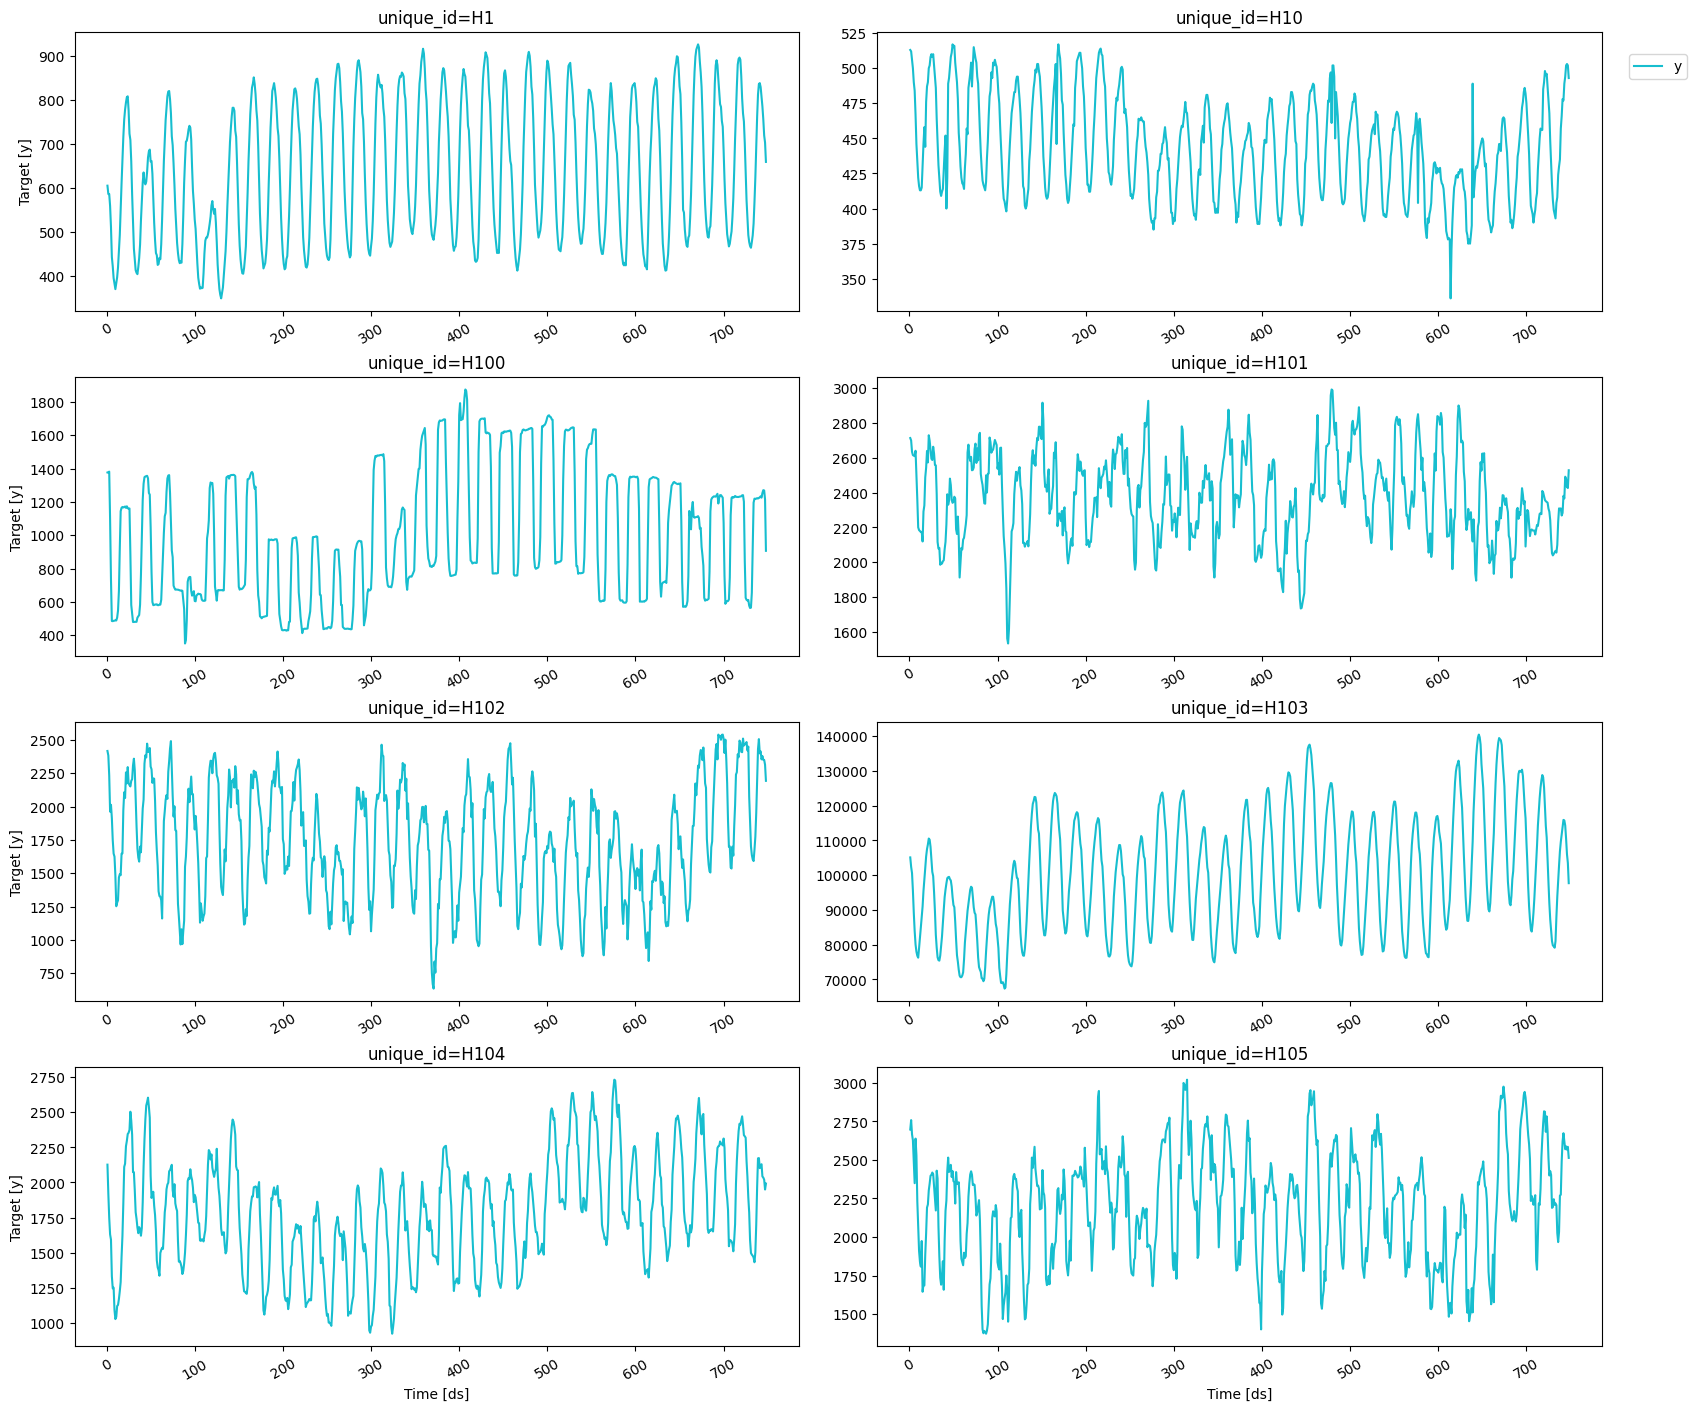

In [40]:
plot_series(df)

### Train Model

To generate the forecast, we'll use the **MSTL** model, which is well-suited for low-frequency data like the one used here. We first need to import it from `statsforecast.models` and then we need to instantiate it. Since we're using hourly data, we have two seasonal periods: one every 24 hours (hourly) and one every 24*7 hours (daily). Hence, we need to set season_length = [24, 24*7].

In [41]:
from statsforecast.models import MSTL

In [ ]:
# Create a list of models and instantiation parameters
models = [MSTL(season_length = [24, 24*7])]

To instantiate a new StatsForecast object, we need the following parameters:
- `models`: The list of models defined in the previous step.
- `freq`: A string or integer indicaton the frequency of the data. See pandas' available frequencies.
- `n_jobs`: An integer that indicates the number of jobs used in parallel processing. Use -1 to delect all cores.

In [43]:
sf = StatsForecast(models = models,
                   freq = 1,
                   n_jobs = -1)

We'll now predict the next 48 hours. To do this, we'll use the `forecast` method, which requires the following arguments:

- `df`: The dataframe with the training data.
- `h`: The forecasting horizon.
- `level`: The confidence levels of the prediction intervals.
- `fitted`: Return insample predictions.

It is important that we select a `level` and set `fitted = True` since we'll need the insample forecasts and their prediction intervals to detect the anomalies.

In [46]:
horizon = 48
levels = [99]

fcst = sf.forecast(df = df, h = 48, level = levels, fitted = True)
fcst.head()

unique_id   ds        MSTL  MSTL-lo-99  MSTL-hi-99
0        H1  749  607.607223  587.173250  628.041196
1        H1  750  552.364253  521.069710  583.658796
2        H1  751  506.785334  465.894977  547.675691
3        H1  752  472.906141  423.114088  522.698195
4        H1  753  452.240231  394.064394  510.416067

We can plot the forecasts using the `plot_series` function from before.

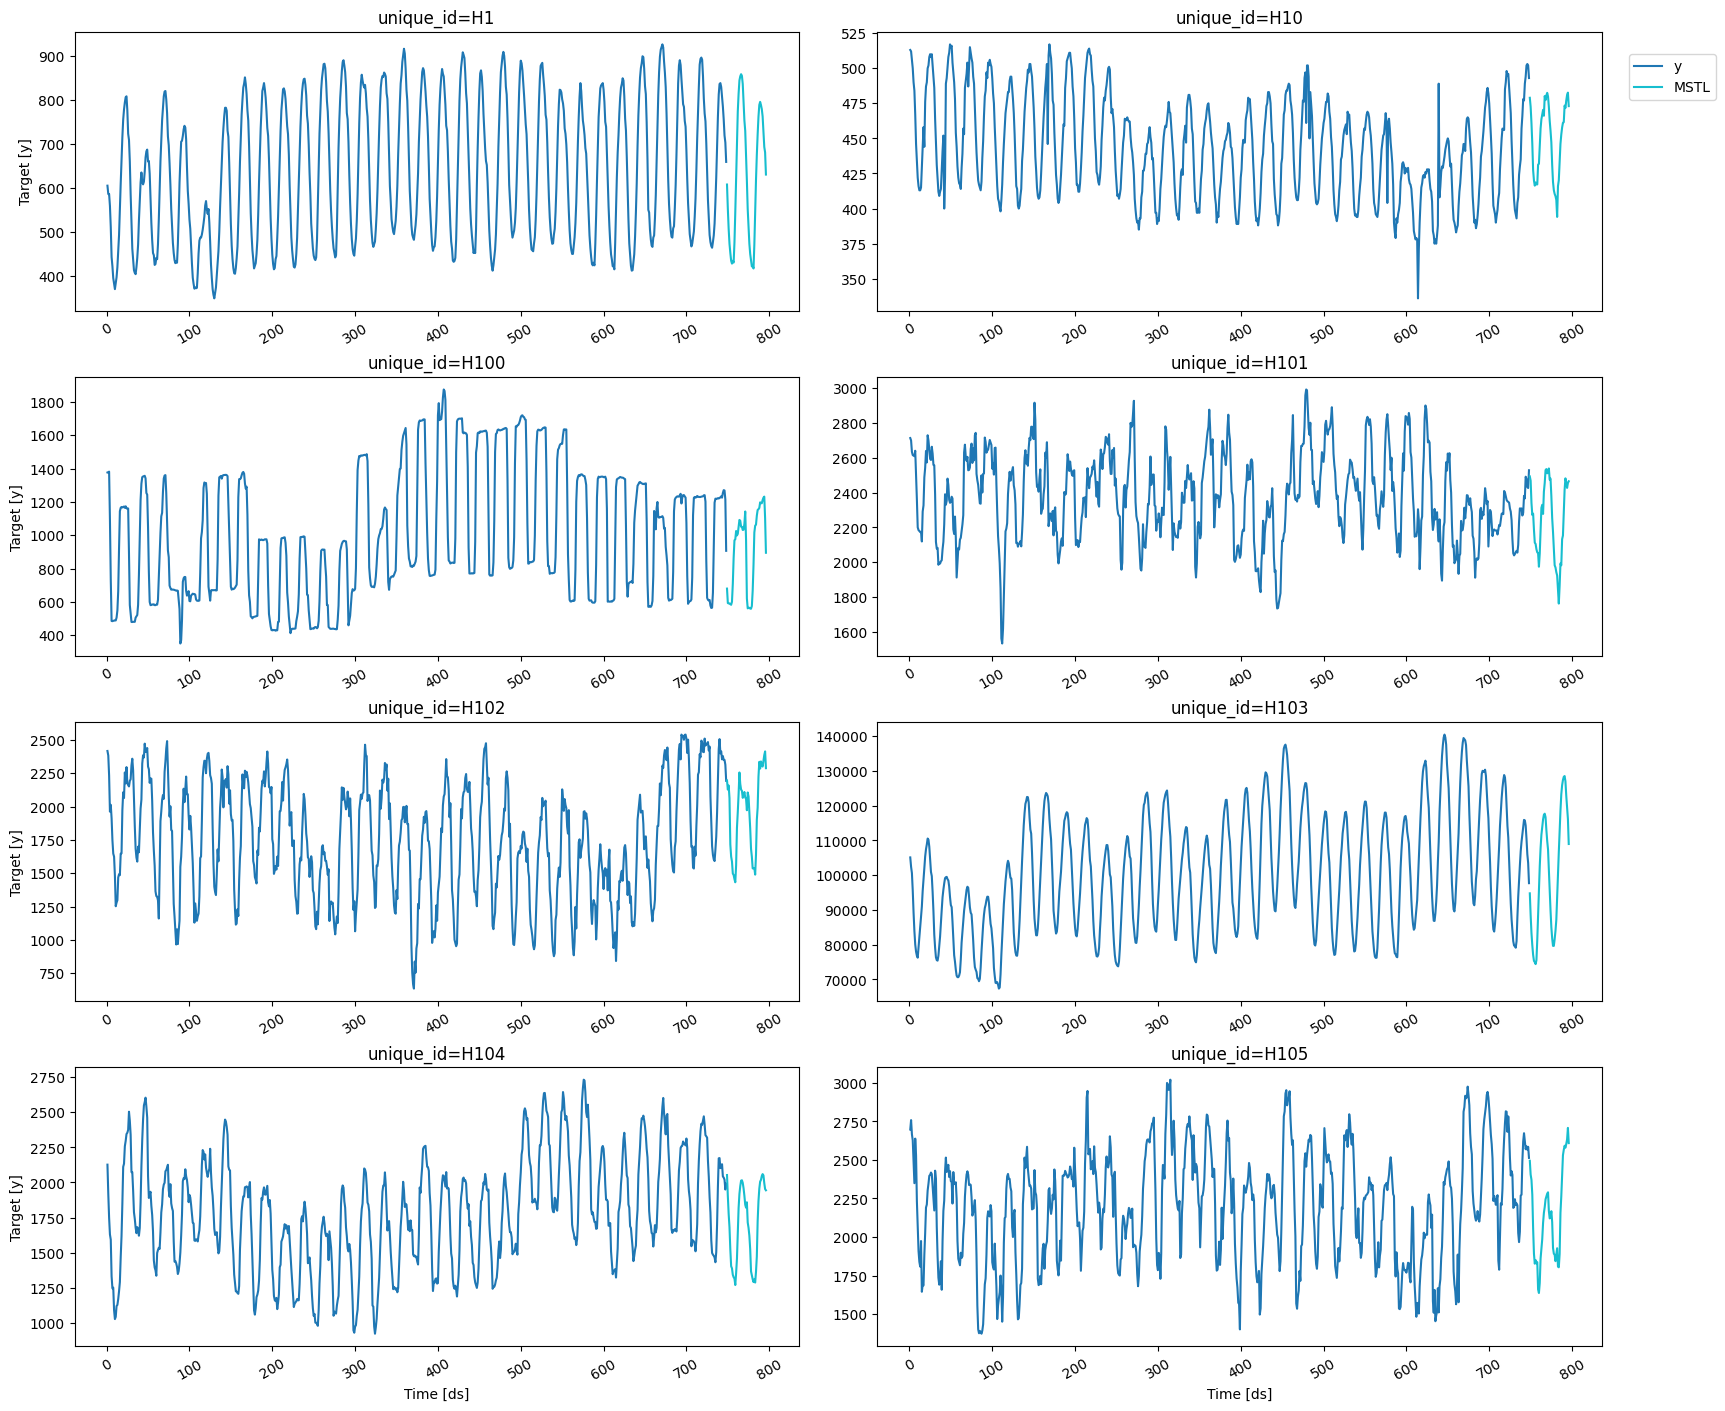

In [47]:
plot_series(df, fcst)

### Recover insample forecasts and identify anomalies

In this example, an **anomaly** will be any observation outside the predition interval of the insample forecasts for a given confidence level (here we selected 99%). Hence, we first need to recover the insample forecasts using the `forecast_fitted_values` method.

In [48]:
insample_forecasts = sf.forecast_fitted_values()
insample_forecasts.head()

unique_id  ds      y        MSTL  MSTL-lo-99  MSTL-hi-99
0        H1   1  605.0  605.098607  584.678408  625.518805
1        H1   2  586.0  588.496673  568.076474  608.916872
2        H1   3  586.0  585.586856  565.166657  606.007054
3        H1   4  559.0  554.012377  533.592178  574.432576
4        H1   5  511.0  510.153508  489.733309  530.573707

We can now find all the observations above or below the 99% prediction interval for the insample forecasts.

In [49]:
anomalies = insample_forecasts[~insample_forecasts['y'].between(insample_forecasts['MSTL-lo-99'], insample_forecasts['MSTL-hi-99'])]
anomalies.head()

unique_id   ds      y        MSTL  MSTL-lo-99  MSTL-hi-99
42         H1   43  613.0  649.404871  628.984672  669.825069
47         H1   48  683.0  662.245526  641.825328  682.665725
48         H1   49  687.0  655.382320  634.962122  675.802519
100        H1  101  507.0  484.934230  464.514031  505.354428
110        H1  111  451.0  474.899006  454.478808  495.319205

We can plot the anomalies by setting the `level` and the `plot_anomalies` arguments of the `plot_series` function.

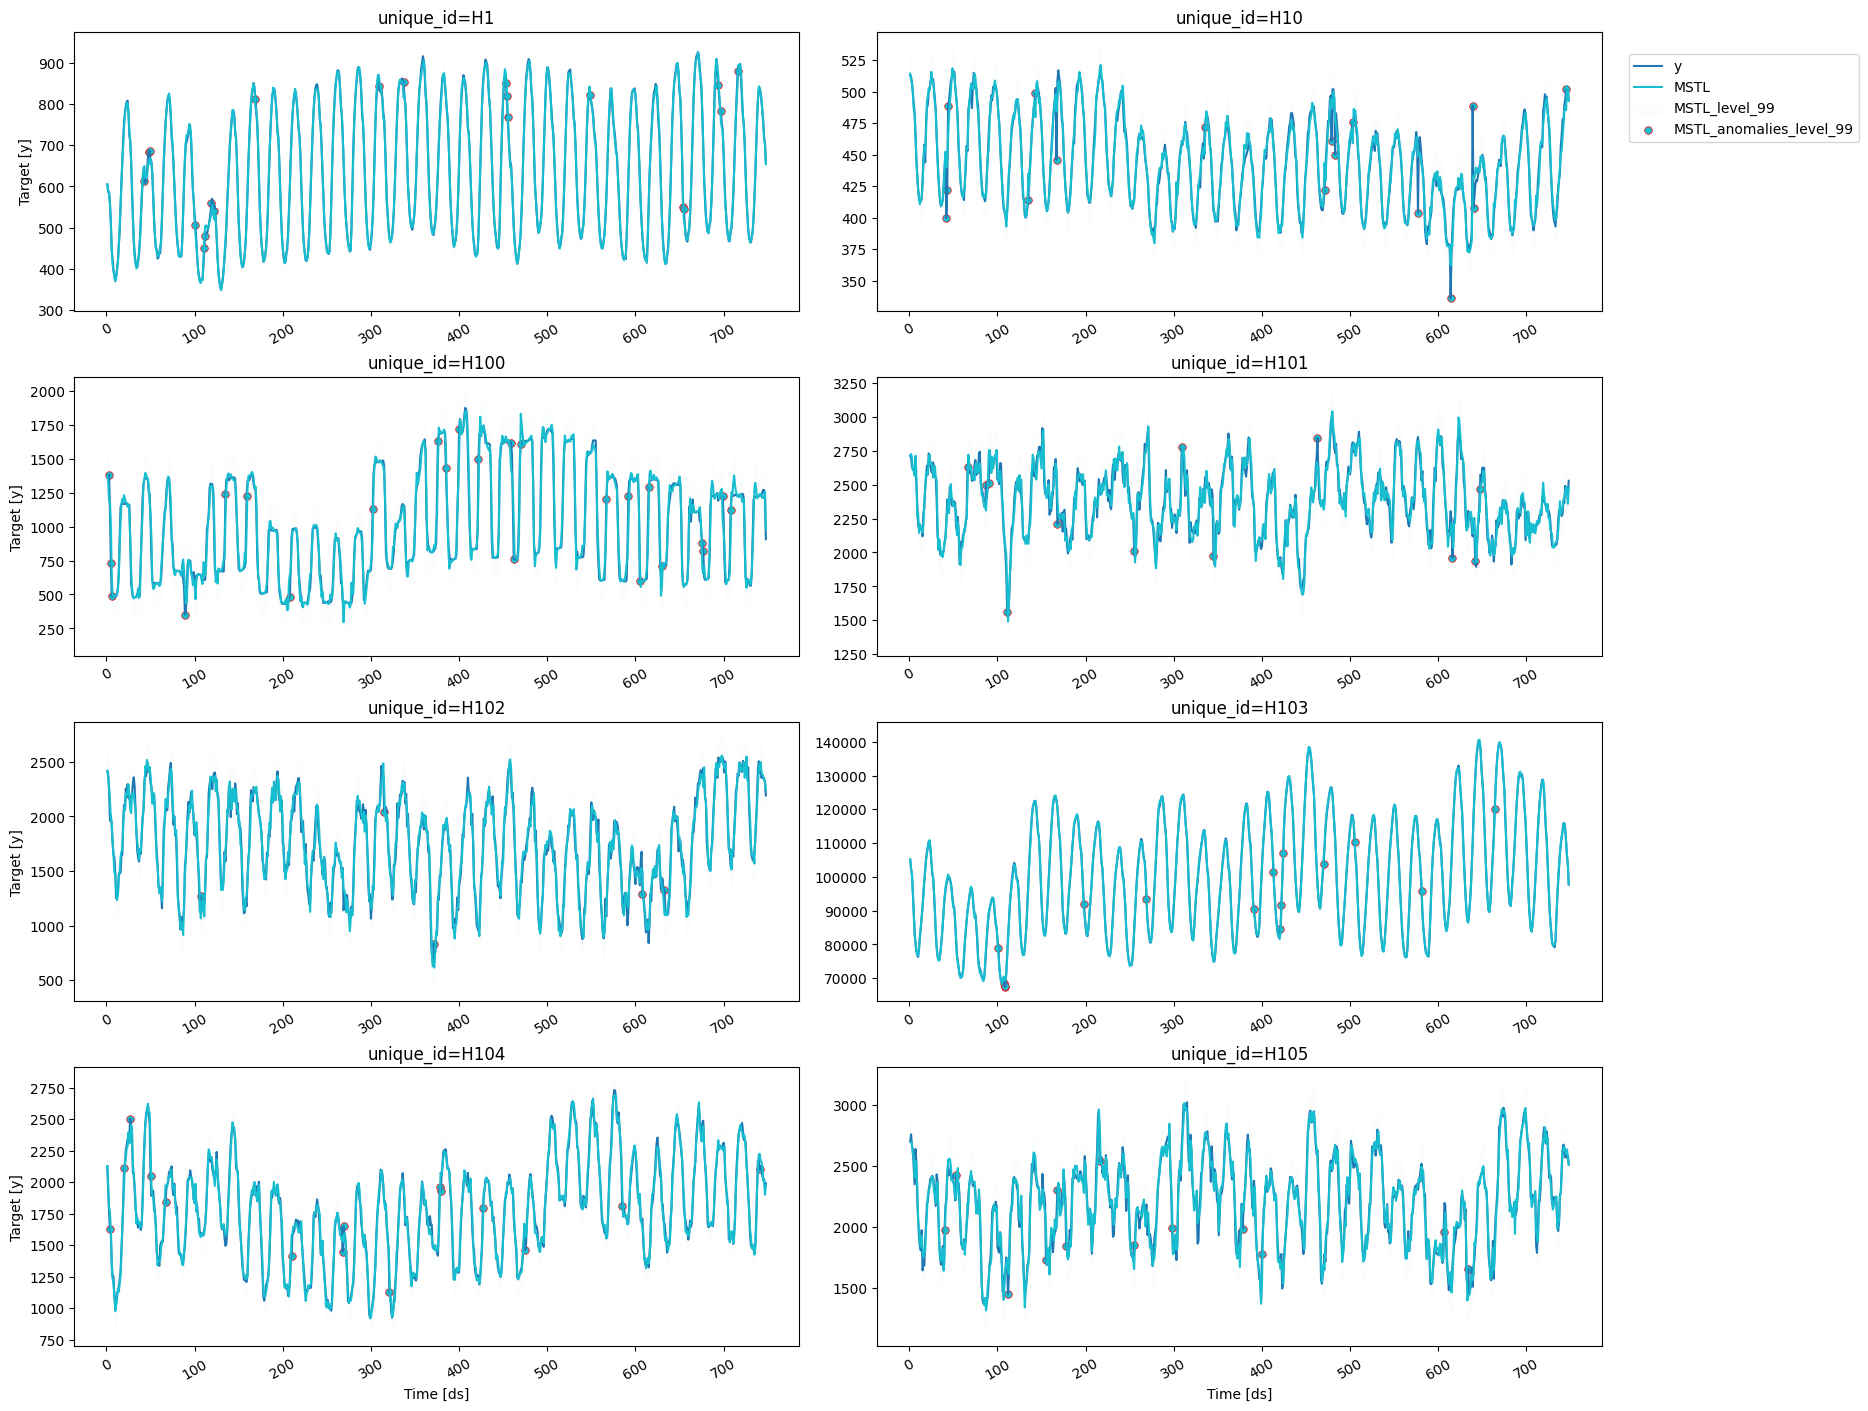

In [50]:
plot_series(forecasts_df = insample_forecasts, level = levels, plot_anomalies = True)

If we want to take a closer look, we can use the `ids` argument to select one particular time series for example, `H10`.

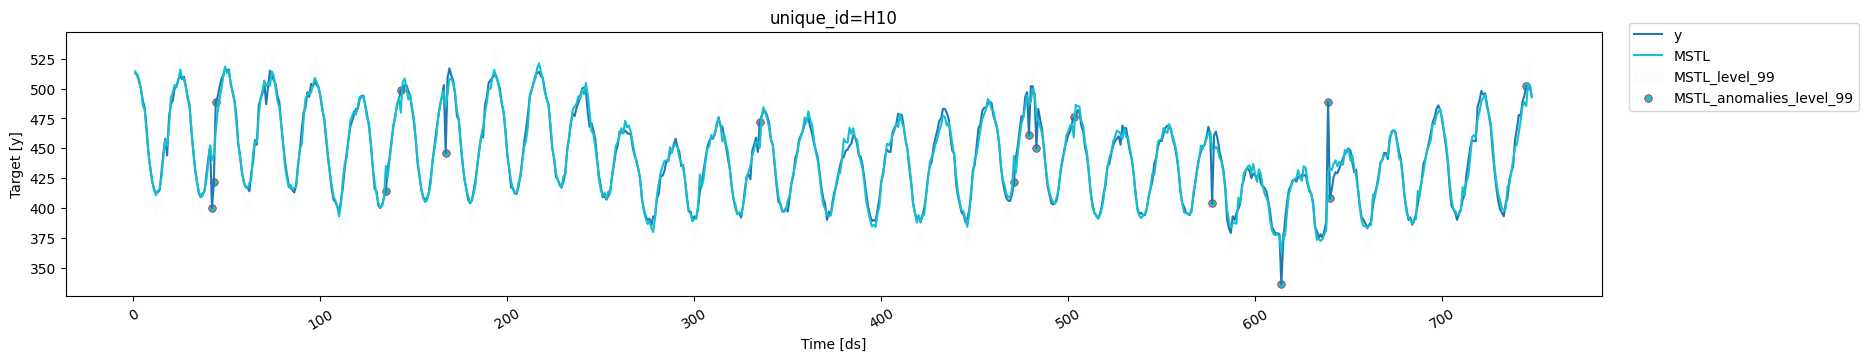

In [51]:
plot_series(forecasts_df = insample_forecasts, level = [99], plot_anomalies = True, ids = ['H10'])

Here we identified the anomalies in the data using the MSTL model, but any **probabilistic model** from StatsForecast can be used. We also selected the 99% prediction interval of the insample forecasts, but other confidence levels can be used as well.

---

## Conformal Prediction

### Introduction

When we generate a forecast, we usually produce a single value known as the point forecast. This value, however, doesn't tell us anything about the uncertainty associated with the forecast. To have a measure of this uncertainty, we need **prediction intervals**.

A prediction interval is a range of values that the forecast can take with a given probability. Hence, a 95% prediction interval should contain a range of values that include the actual future value with probability 95%. Probabilistic forecasting aims to generate the full forecast distribution. Point forecasting, on the other hand, usually returns the mean or the median or said distribution. However, in real-world scenarios, it is better to forecast not only the most probable future outcome, but many alternative outcomes as well.

The problem is that some timeseries models provide forecast distributions, but some other ones only provide point forecasts. How can we then estimate the uncertainty of predictions?

### Conformal Prediction

Multi-quantile losses and statistical models can provide provide prediction intervals, but the problem is that these are uncalibrated, meaning that the actual frequency of observations falling within the interval does not align with the confidence level associated with it. For example, a calibrated 95% prediction interval should contain the true value 95% of the time in repeated sampling. An uncalibrated 95% prediction interval, on the other hand, might contain the true value only 80% of the time, or perhaps 99% of the time. In the first case, the interval is too narrow and underestimates the uncertainty, while in the second case, it is too wide and overestimates the uncertainty.

Statistical methods also assume normality. Here, we talk about another method called conformal prediction that doesn’t require any distributional assumptions.

Conformal prediction intervals use cross-validation on a point forecaster model to generate the intervals. This means that no prior probabilities are needed, and the output is well-calibrated. No additional training is needed, and the model is treated as a black box. The approach is compatible with any model.

In [52]:
train = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
test = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv').rename(columns={'y': 'y_test'})
train.head()

unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0

Since the goal of this notebook is to generate prediction intervals, we'll only use the first 8 series of the dataset to reduce the total computational time.

In [53]:
n_series = 8 
uids = train['unique_id'].unique()[:n_series] # select first n_series of the dataset
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

We can plot these series using the plot_series function from the utilsforecast library. This function method has multiple parameters, and the requirred ones to generate the plots in this notebook are explained below.

- `df`: A `pandas` dataframe with columns [`unique_id`, `ds`, `y`].
- `forecasts_df`: A `pandas` dataframe with columns [`unique_id`, `ds`] and models.
- `plot_random`: bool = `True`. Plots the time series randomly.
- `models`: List[str]. A list with the models we want to plot.
- `level`: List[float]. A list with the prediction intervals we want to plot.
- `engine`: str = `matplotlib`. It can also be `plotly`. `plotly` generates interactive plots, while `matplotlib` generates static plots.

In [54]:
from utilsforecast.plotting import plot_series

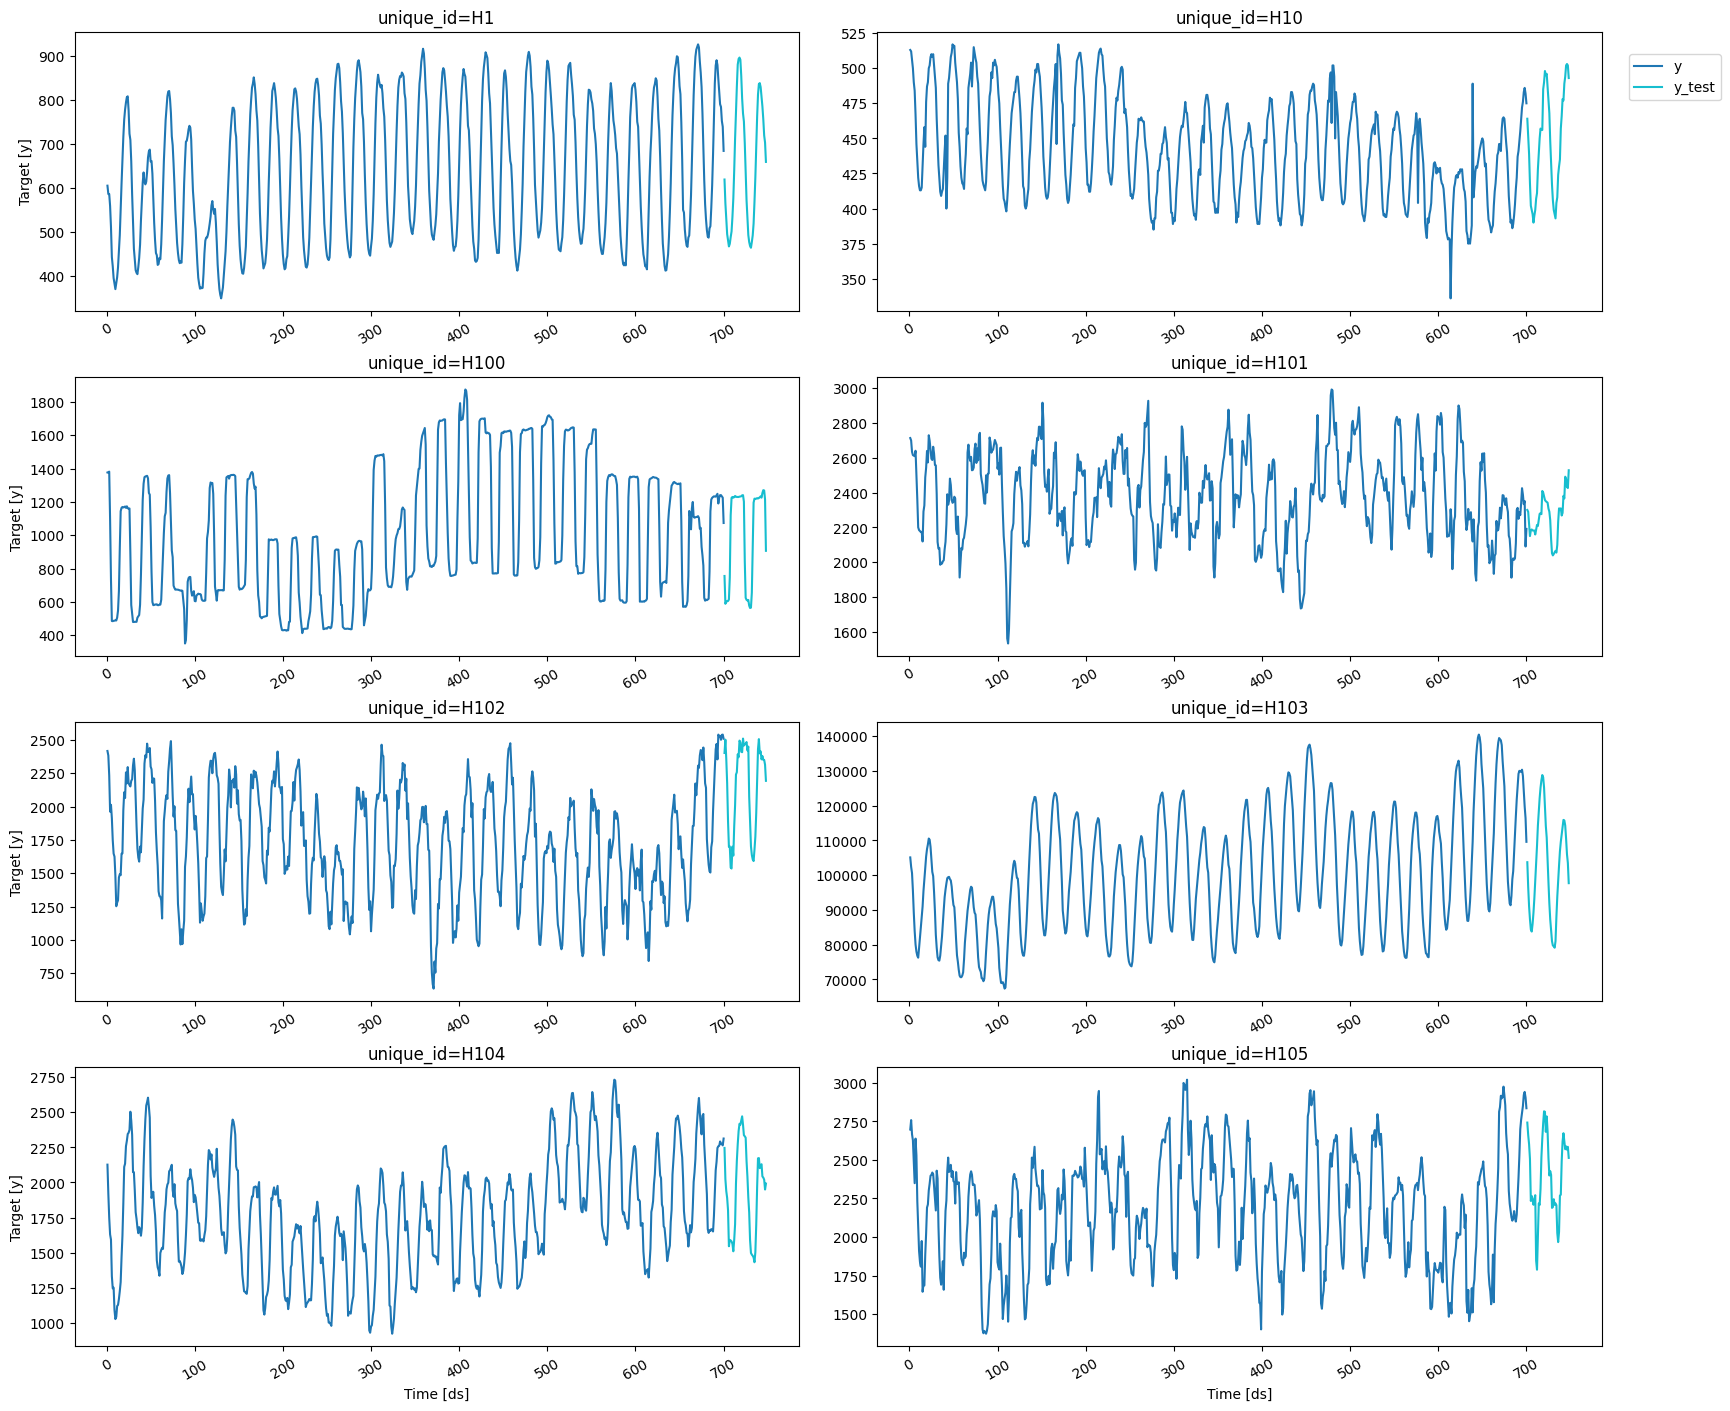

In [ ]:
plot_series(train, test, plot_random = False)

### Train Models

StatsForecast can train multiple **models** on different time series efficiently. Most of these models can generate a probabilistic forecast, which means that they can produce both point forecasts and prediction intervals.

For this example, we'll use **SimpleExponentialSmoothing** and **ADIDA** which do not provide a prediction interval natively. Thus, it makes sense to use Conformal Prediction to generate the prediction interval.

We'll also show using it with **ARIMA** to provide prediction intervals that don't assume normality.

To use these models, we first need to import them from `statsforecast.models` and then we need to instantiate them.

In [56]:
from statsforecast.models import SeasonalExponentialSmoothing, ADIDA, ARIMA
from statsforecast.utils import ConformalIntervals

# Create a list of models and instantiation parameters
intervals = ConformalIntervals(h = 24, n_windows = 2)
# P.S. n_windows * h should be less than the count of data elements in your time series sequence.
# P.S. Also value of n_windows should be atleast 2 or more.

models = [
    SeasonalExponentialSmoothing(season_length = 24, alpha = 0.1, prediction_intervals = intervals),
    ADIDA(prediction_intervals = intervals),
    ARIMA(order = (24, 0, 12), prediction_intervals = intervals),
]

To instantiate a new StatsForecast object, we need the following parameters:

- `df`: The dataframe with the training data.
- `models`: The list of models defined in the previous step.
- `freq`: A string indicating the frequency of the data. See **panda's available frequencies**.
- `n_jobs`: An integer that indicates the number or jobs used in parallel processing. Use -1  to select all cores.

In [57]:
sf = StatsForecast(models = models, freq = 1, n_jobs = -1)

Now we're ready to generate the forecasts and the prediction intervals. To do this, we'll use the `forecast` method, which takes two arguments:

- `h`: An integer that represent the represent the forecasting horizon. In this case, we'll forecast. 
- `level`: A list of floats with the confidence levels of the prediction intervals. For example, `level= [95] means that the range of values should include the actual future value with probability 95%.

In [58]:
levels = [80, 90] #confidence levels of the prediction intervals

forecasts = sf.forecast(df = train, h = 24, level = levels)
forecasts.head()

unique_id   ds  SeasonalES  SeasonalES-lo-90  SeasonalES-lo-80  \
0        H1  701  624.132703        553.097423        556.359139   
1        H1  702  555.698193        496.653559        506.833156   
2        H1  703  514.403029        462.673117        464.939840   
3        H1  704  482.057899        433.030711        436.161413   
4        H1  705  460.222522        414.270186        416.959492   

   SeasonalES-hi-80  SeasonalES-hi-90       ADIDA  ADIDA-lo-90  ADIDA-lo-80  \
0        691.906266        695.167983  747.293233   599.519653   600.030880   
1        604.563231        614.742827  747.293233   491.669653   498.330880   
2        563.866218        566.132941  747.293233   475.105378   475.794151   
3        527.954385        531.085087  747.293233   440.069653   440.130880   
4        503.485552        506.174858  747.293233   415.805378   416.194151   

   ADIDA-hi-80  ADIDA-hi-90       ARIMA  ARIMA-lo-90  ARIMA-lo-80  \
0   894.555585   895.066812  618.181100   609.481343   610.560864   
1   996.255585  1002.916812  550.119794   510.984169   515.654007   
2  1018.792314  1019.481087  508.531752   496.675932   497.068752   
3  1054.455585  1054.516812  487.196809   471.605260   471.988251   
4  1078.392314  1078.781087  470.979191   445.698210   447.394534   

   ARIMA-hi-80  ARIMA-hi-90  
0   625.801336   626.880857  
1   584.585581   589.255419  
2   519.994753   520.387573  
3   502.405368   502.788358  
4   494.563847   496.260171

### Plot prediction intervals

Here we'll plot the different intervals for one timeseries.

The prediction interval with the SeasonalExponentialSmoothing seen below. Even if the model generates a point forecast, we are able to get a prediction interval. The  80% prediction interval does not cross the 90% prediction interval, which is a sign that the intervals are calibrated.

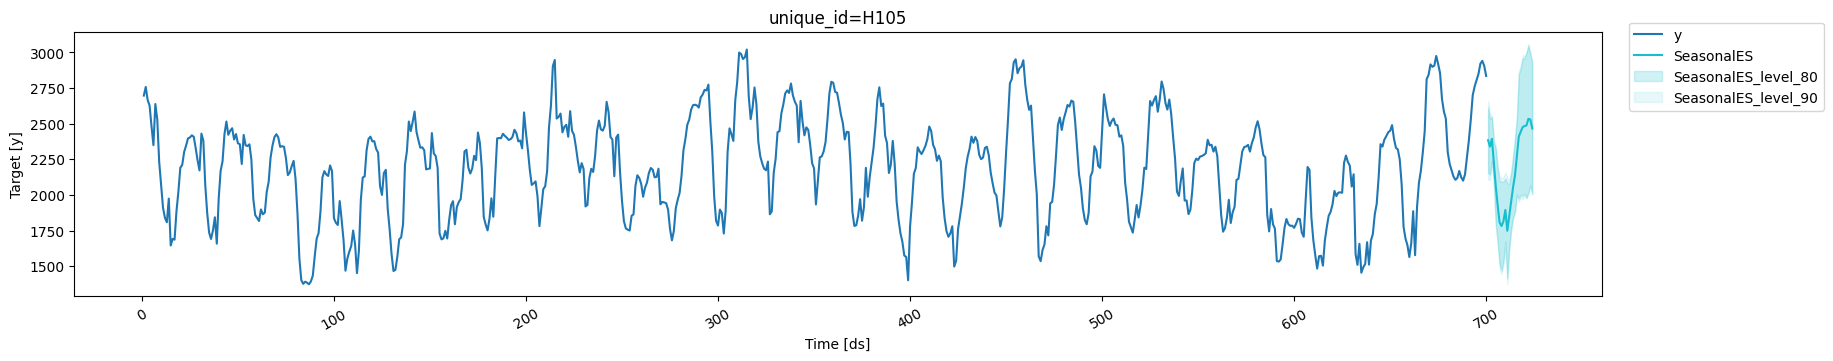

In [59]:
plot_series(train, forecasts, level = levels, ids = ['H105'], models = ['SeasonalES'])

For weaker fitting models, the conformal prediction intervalo can be larger. A better model corresponds to a narrower interval.

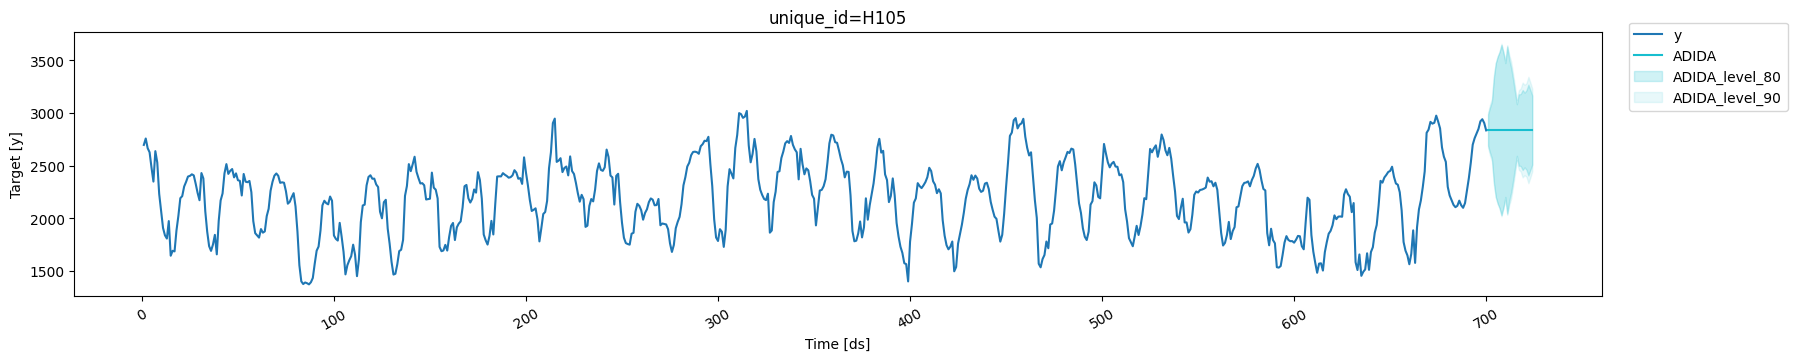

In [60]:
plot_series(train, forecasts, level = levels, ids = ['H105'], models = ['ADIDA'])

ARIMA is an example of a model that provides a forecast distribution, but we can still use conformal prediction to generate the prediction interval. As mentioned earlier, this method has the benefit of not assuming normality.

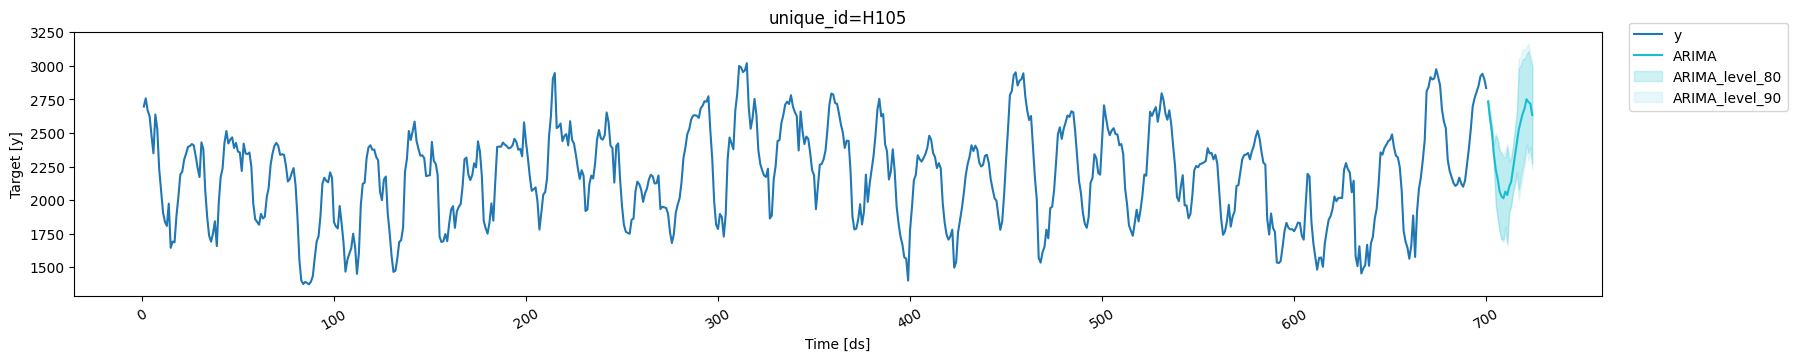

In [61]:
plot_series(train, forecasts, level = levels, ids = ['H105'], models = ['ARIMA'])

### StatsForecast Object

Alternatively, the prediction interval can be defined on the StatsForecast object. This will apply to all models that don't have the `prediction_intervals` defined.

In [62]:
from statsforecast.models import SimpleExponentialSmoothing, ADIDA
from statsforecast.utils import ConformalIntervals
from statsforecast import StatsForecast

models = [
    SimpleExponentialSmoothing(alpha = 0.1),
    ADIDA()
]

res = StatsForecast(
    models = models, 
    freq = 1,
).forecast(df = train, h = 24, prediction_intervals = ConformalIntervals(h = 24, n_windows = 2), level = [80]) 
res.head()

unique_id   ds         SES   SES-lo-80    SES-hi-80       ADIDA  \
0        H1  701  742.669064  649.221405   836.116722  747.293233   
1        H1  702  742.669064  550.551324   934.786804  747.293233   
2        H1  703  742.669064  523.621405   961.716722  747.293233   
3        H1  704  742.669064  488.121405   997.216722  747.293233   
4        H1  705  742.669064  464.021405  1021.316722  747.293233   

   ADIDA-lo-80  ADIDA-hi-80  
0   600.030880   894.555585  
1   498.330880   996.255585  
2   475.794151  1018.792314  
3   440.130880  1054.455585  
4   416.194151  1078.392314

---


## Cross Validation

In this example, we'll implement time series cross-validation to evaluate model's performance.

### Introduction

Time series cross-validation is a method for evaluation how a model would have performend in the past. It works by defining a sliding window across the historical data and predicting the period following it.

### Load and Explore the Data

As stated in the introduction, we'll use the M4 Competition hourly dataset. We'll first import the data from an URL using `pandas`.

In [63]:
Y_df = pd.read_parquet('https://datasets-nixtla.s3.amazonaws.com/m4-hourly.parquet') # load the data 
Y_df.head()

unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0

The input to StatsForecast is a data frame in long format with three columns: `unique_id`, `ds` and `y`:

- The `unique_id` (string, int, or category) represents an identifier for the series.
- The `ds` (datestamp or int) column should be either an integer indexing time or a datestamp in format YYYY-MM-DD or YYYY-MM-DD HH:MM:SS.
- The `y` (numeric) represents the measurement we wish to forecast.

The data in this example already has this format, so no changes are needed.

To keep the time required to execute this notebook to a minimum, we’ll only use one time series from the data, namely the one with `unique_id == 'H1'`. However, you can use as many as you want, with no additional changes to the code needed.

In [65]:
df = Y_df[Y_df['unique_id'] == 'H1'] # Select time series

We can plot the time series we'll work with using StatsForecast.plot method.

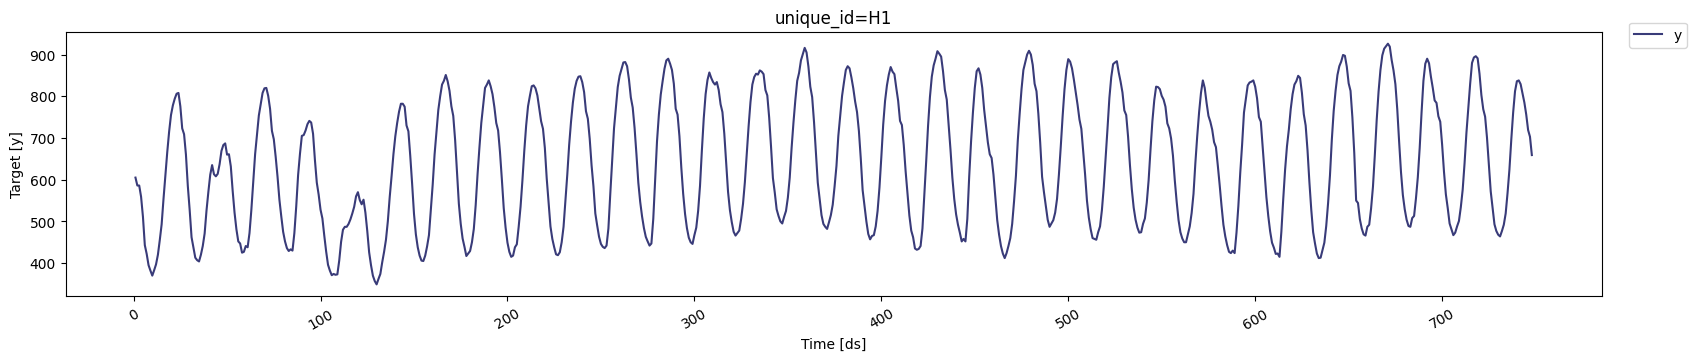

In [66]:
StatsForecast.plot(df)

### Train Model

For this example, we’ll use StastForecast **AutoETS**. We first need to import it from `statsforecast.models` and then we need to instantiate a new `StatsForecast` object.
The `StatsForecast` object has the following parameters:

- models: a list of models. Select the models you want from **models** and import them.
- freq: a string indicating the frequency of the data. See **panda’s available frequencies**.
- n_jobs: n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame `df`.

In [67]:
from statsforecast.models import AutoETS

In [68]:
models = [AutoETS(season_length = 24)]

sf = StatsForecast(
    models = models,
    freq = 1,
    n_jobs = 1
)

### Perform time series cross-validation

Once the StatsForecast objet has been instantiated, we can use the `cross_validation` method, which takes the following arguments:

- `df`: training data frame with `StatsForecast` format.
- `h`: (int): represents the h steps into the future that will be forecasted.
- `step_size` (int): step size between each window, meaning how often do you want to run the forecasting process.
- `n_windows` (int): number of window used for cross-validation, meaning the number of forecasting processes in the pasto you want to evaluate.

For this particular example, we'll use 3 windows of 24 hours.

In [69]:
cv_df = sf.cross_validation(
    df = df,
    h = 24,
    step_size = 24,
    n_windows = 3
)

The `cv_df` object is a new data frame that includes the following columns:

- `unique_id`: series identifier.
- `ds`: datestamp or temporal index.
- `cutoff`: the last datestamp or temporal index for the n_windows.
- `y`: true value.
- `"model"`: columns with the model's name and fitted value.

In [70]:
cv_df.head()

unique_id   ds  cutoff      y     AutoETS
0        H1  677     676  691.0  677.761053
1        H1  678     676  618.0  607.817879
2        H1  679     676  563.0  569.437729
3        H1  680     676  529.0  537.340007
4        H1  681     676  504.0  515.571123

We'll now plot the forecast for each cutoff period. To make the plots clearer, we'll rename the actual values in each period.

In [71]:
from IPython.display import display

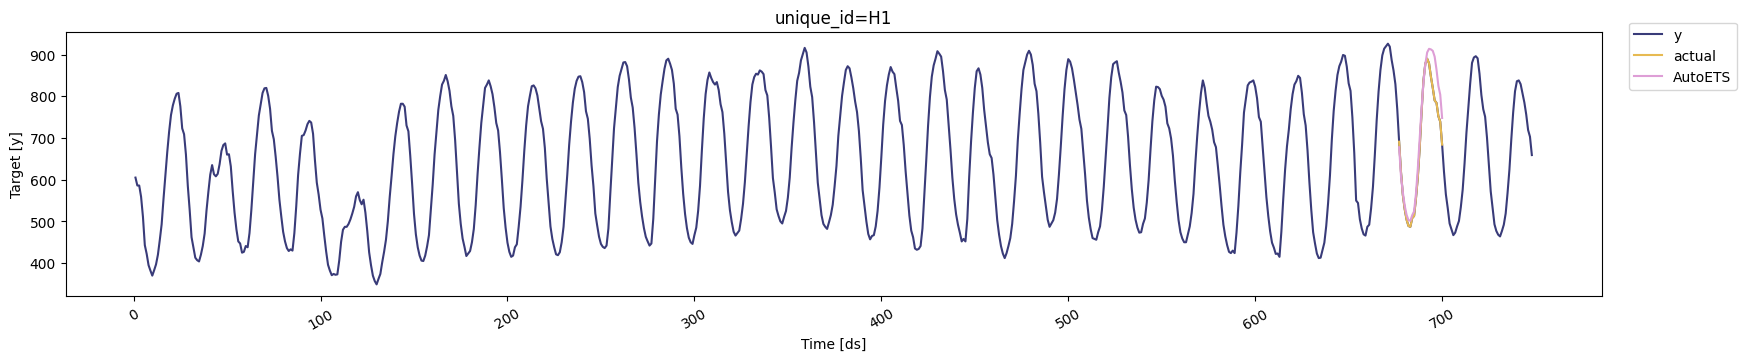

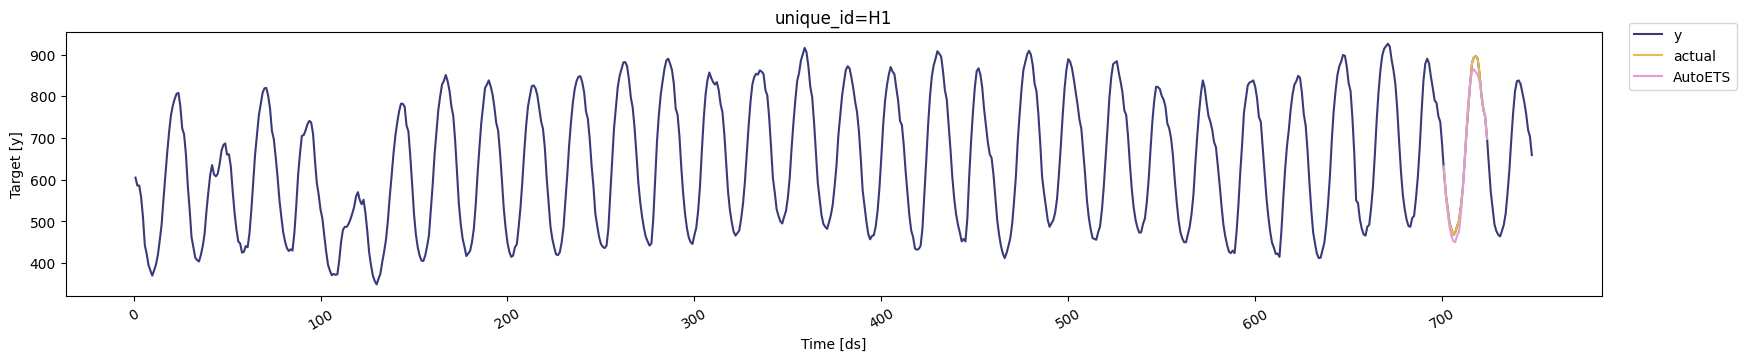

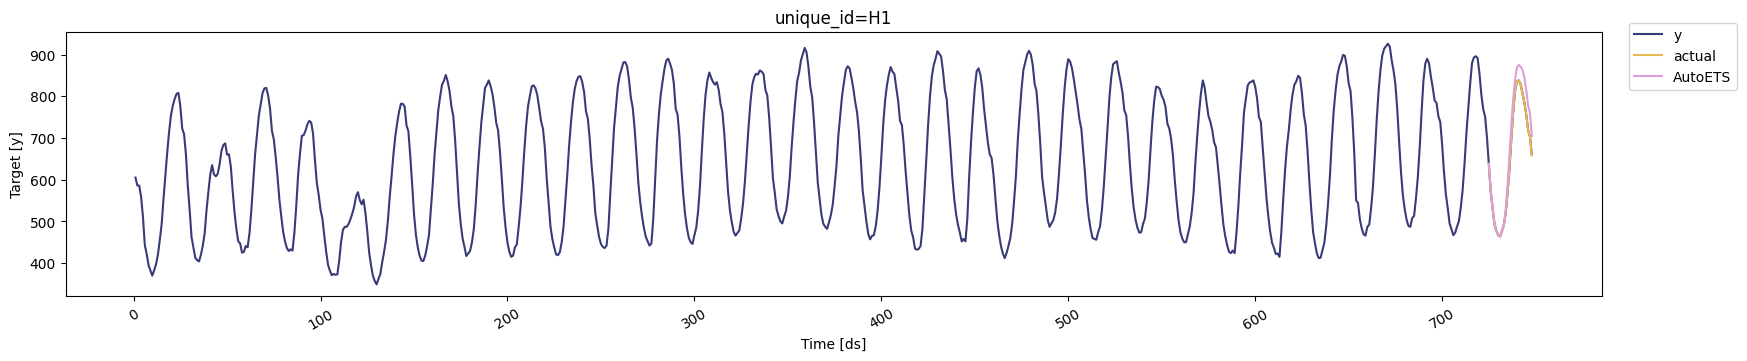

In [72]:
cv_df.rename(columns = {'y' : 'actual'}, inplace = True) # rename actual values

cutoff = cv_df['cutoff'].unique()

for k in range(len(cutoff)):
    cv = cv_df[cv_df['cutoff'] == cutoff[k]]
    display(StatsForecast.plot(df, cv.loc[:, cv.columns != 'cutoff']))

Notice that in each cutoff period, we generate a forecast for the next 24 hours using only the data `y` before said period.

### Evaluate results

We can now compute the accuracy of the forecast using an appropiate accuracy metric. Here we'll use the Root Mean Squared Error (RMSE).

In [73]:
from utilsforecast.losses import rmse

The function to compute the RMSE takes two arguments:

1. The actual values.
2. The forecasts, in this case, AutoETS.

In [95]:
cv_rmse = rmse(cv_df, models = ['AutoETS'], target_col = 'actual')['AutoETS'].item()
print(f"RMSE using cross-validation: {cv_rmse:.2f}")

RMSE using cross-validation: 33.90


This measure should better reflect the predictive abilities of our model, since it used different time periods to test its accuracy.

**Tip**. Cross validation is especially useful when comparing multiple models. Here's an **example** with multiple models and time series.

---

## Intermittent or Sparse Data

Intermittent or sparse data has very few non-zero observations. This type of data is  hard to forecast because the zero values increase the uncertainty about the underlying patterns in the data. Furthermore, once a non-zero observation occurs, there can be considerable variation in its size.

Intermittent time series are common in many industries, iincludiing finance, retail, transportation, and energy. Given the ubiquity of this type of series, special methods have been developed to forecast them. The first was from **Croston (1972)**, followed by several variants and by different aggregation frameworks.

**StatsForecast** has implemented several models to forecast intermittent time series. By the end of this tutorial, you'll have a good understanding of these models and how to use them.

### Load and Explore the Data

For this example, we'll use a subset of the M5 Competition dataset. Each time series represents the unit sales of a particular product in a given Walmart store. At this level (product-store), most  of the data is intermittent. We first need to import the data.

In [111]:
uids = [
    'FOODS_1_001_CA_1',
    'FOODS_1_001_CA_2',
    'FOODS_1_001_CA_3',
    'FOODS_1_001_CA_4',
    'FOODS_1_001_TX_1',
    'FOODS_1_001_TX_2',
    'FOODS_1_001_TX_3',
    'FOODS_1_001_WI_1',
]
df = pd.read_parquet(
    'https://datasets-nixtla.s3.amazonaws.com/m5_y.parquet',
    filters=[('unique_id', 'in', uids)],
)

We can plot these series using the `plot_series` function from `utilsforecast.plotting`. This function has multiple parameters, and the required ones to generate the plots in this notebook are explained below.

- df: A pandas dataframe with columns  [unique_id, ds, y]
- forecast_df: A pandas dataframe with columns  [unique_id, ds] and models.
- plot_random: Plots the time series randomly.
- max_insample_length: The maximum number of train/insample observations to be plotted.
- engine: The library used to generate the plots. It can also be matplotlib for static plots.

In [76]:
from utilsforecast.plotting import plot_series

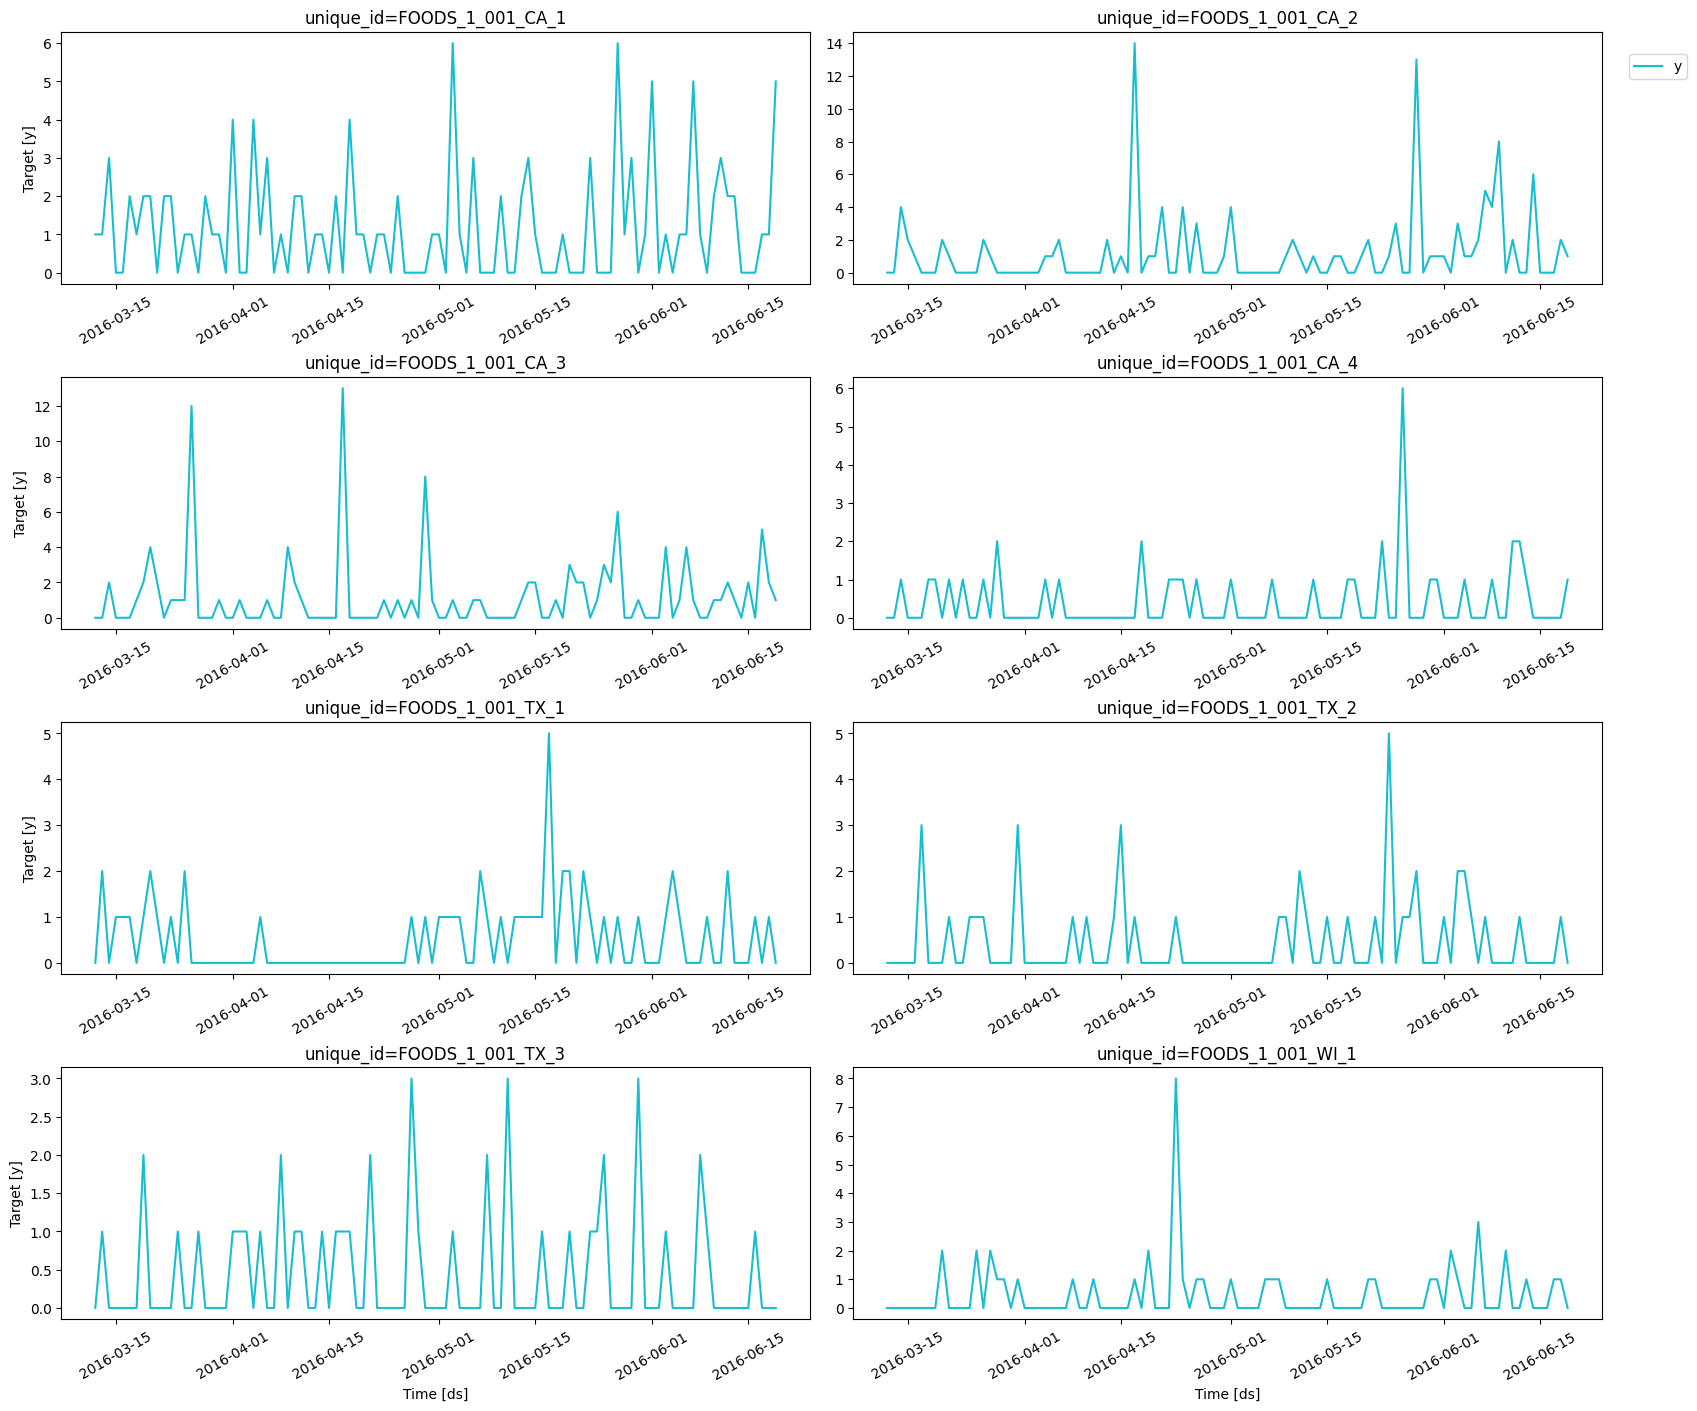

In [112]:
plot_series(df, plot_random=False, max_insample_length=100)

Here we only plotted the last 100 observations, but we can visualize the complete history by removing `max_insample_length`. From these plots, we can confirm that the data is indeed intermittent since it has multiple periods with zero sales. In fact, in all cases but one, the median value is zero.

In [113]:
df.groupby('unique_id', observed=True)['y'].median()

unique_id
FOODS_1_001_CA_1    0.0
FOODS_1_001_CA_2    1.0
FOODS_1_001_CA_3    0.0
FOODS_1_001_CA_4    0.0
FOODS_1_001_TX_1    0.0
FOODS_1_001_TX_2    0.0
FOODS_1_001_TX_3    0.0
FOODS_1_001_WI_1    0.0
Name: y, dtype: float32

### Train models for intermittent data

Before training any model, we need to separate the data in a train and a test set. The M5 Competition used the last 28 days as test set, so we'll do the same.

In [114]:
valid_start = df['ds'].unique()[-28]

train = df[df['ds'] < valid_start]
test = df[df['ds'] >= valid_start]

StatsForecast has efficient implementations of multiple models for intermittent data. The complete list of models available is https://nixtlaverse.nixtla.io/statsforecast/src/core/models.html#sparse-or-intermittent. In this notebook, we'll use:

- **Agregate-Disagregate Intermittent Demand Approach (ADIDA)**
- **Croston Classic**
- **Intermittent Multiple Aggregation prediction Algorithm (IMAPA)**
- **Teunter-Syntetos-Babai (TSB)**

To use these models, we first need to import them from statsforecast.models and then we need to instantiate them.

In [115]:
from statsforecast import StatsForecast
from statsforecast.models import (
    ADIDA,
    CrostonClassic, 
    IMAPA, 
    TSB
)

# Create a list of models and instantiation parameters 
models = [
    ADIDA(), 
    CrostonClassic(), 
    IMAPA(), 
    TSB(alpha_d = 0.2, alpha_p = 0.2)
]

To instantiate a new StatsForecast object, we need the following parameters:

- `models`: The list of models defined in the previous step.
- `freq`: A string indicating the frequency of the data. See **panda's available frequencies**.
- `n_jobs`: An integer that indicates the number of jobs used in parallel processing. Use -1 to select all cores.

In [116]:
sf = StatsForecast(
    models=models, 
    freq='D', 
    n_jobs=-1,
)

Now we're ready to generate the forecast. To do this, we'll use the `forecast` method, which requires the forecasting horizon (in this case, 28 days) as argument.

The models for intermittent series that are currently available in StatsForecast can only generate point-forecasts. If prediction intervals are needed, then a **probabilistic model** should be used.

In [117]:
horizon = 28 
forecasts = sf.forecast(df=train, h=horizon)
forecasts.head()

unique_id         ds     ADIDA  CrostonClassic     IMAPA       TSB
0  FOODS_1_001_CA_1 2016-05-23  0.791843        0.898247  0.705822  0.434313
1  FOODS_1_001_CA_1 2016-05-24  0.791843        0.898247  0.705822  0.434313
2  FOODS_1_001_CA_1 2016-05-25  0.791843        0.898247  0.705822  0.434313
3  FOODS_1_001_CA_1 2016-05-26  0.791843        0.898247  0.705822  0.434313
4  FOODS_1_001_CA_1 2016-05-27  0.791843        0.898247  0.705822  0.434313

Finally, we'll merge the forecast with the actual values.

In [118]:
test = test.merge(forecasts, how='left', on=['unique_id', 'ds'])

### Plot forecasts and compute accuracy

We can generate plots using the plot_series function described above.

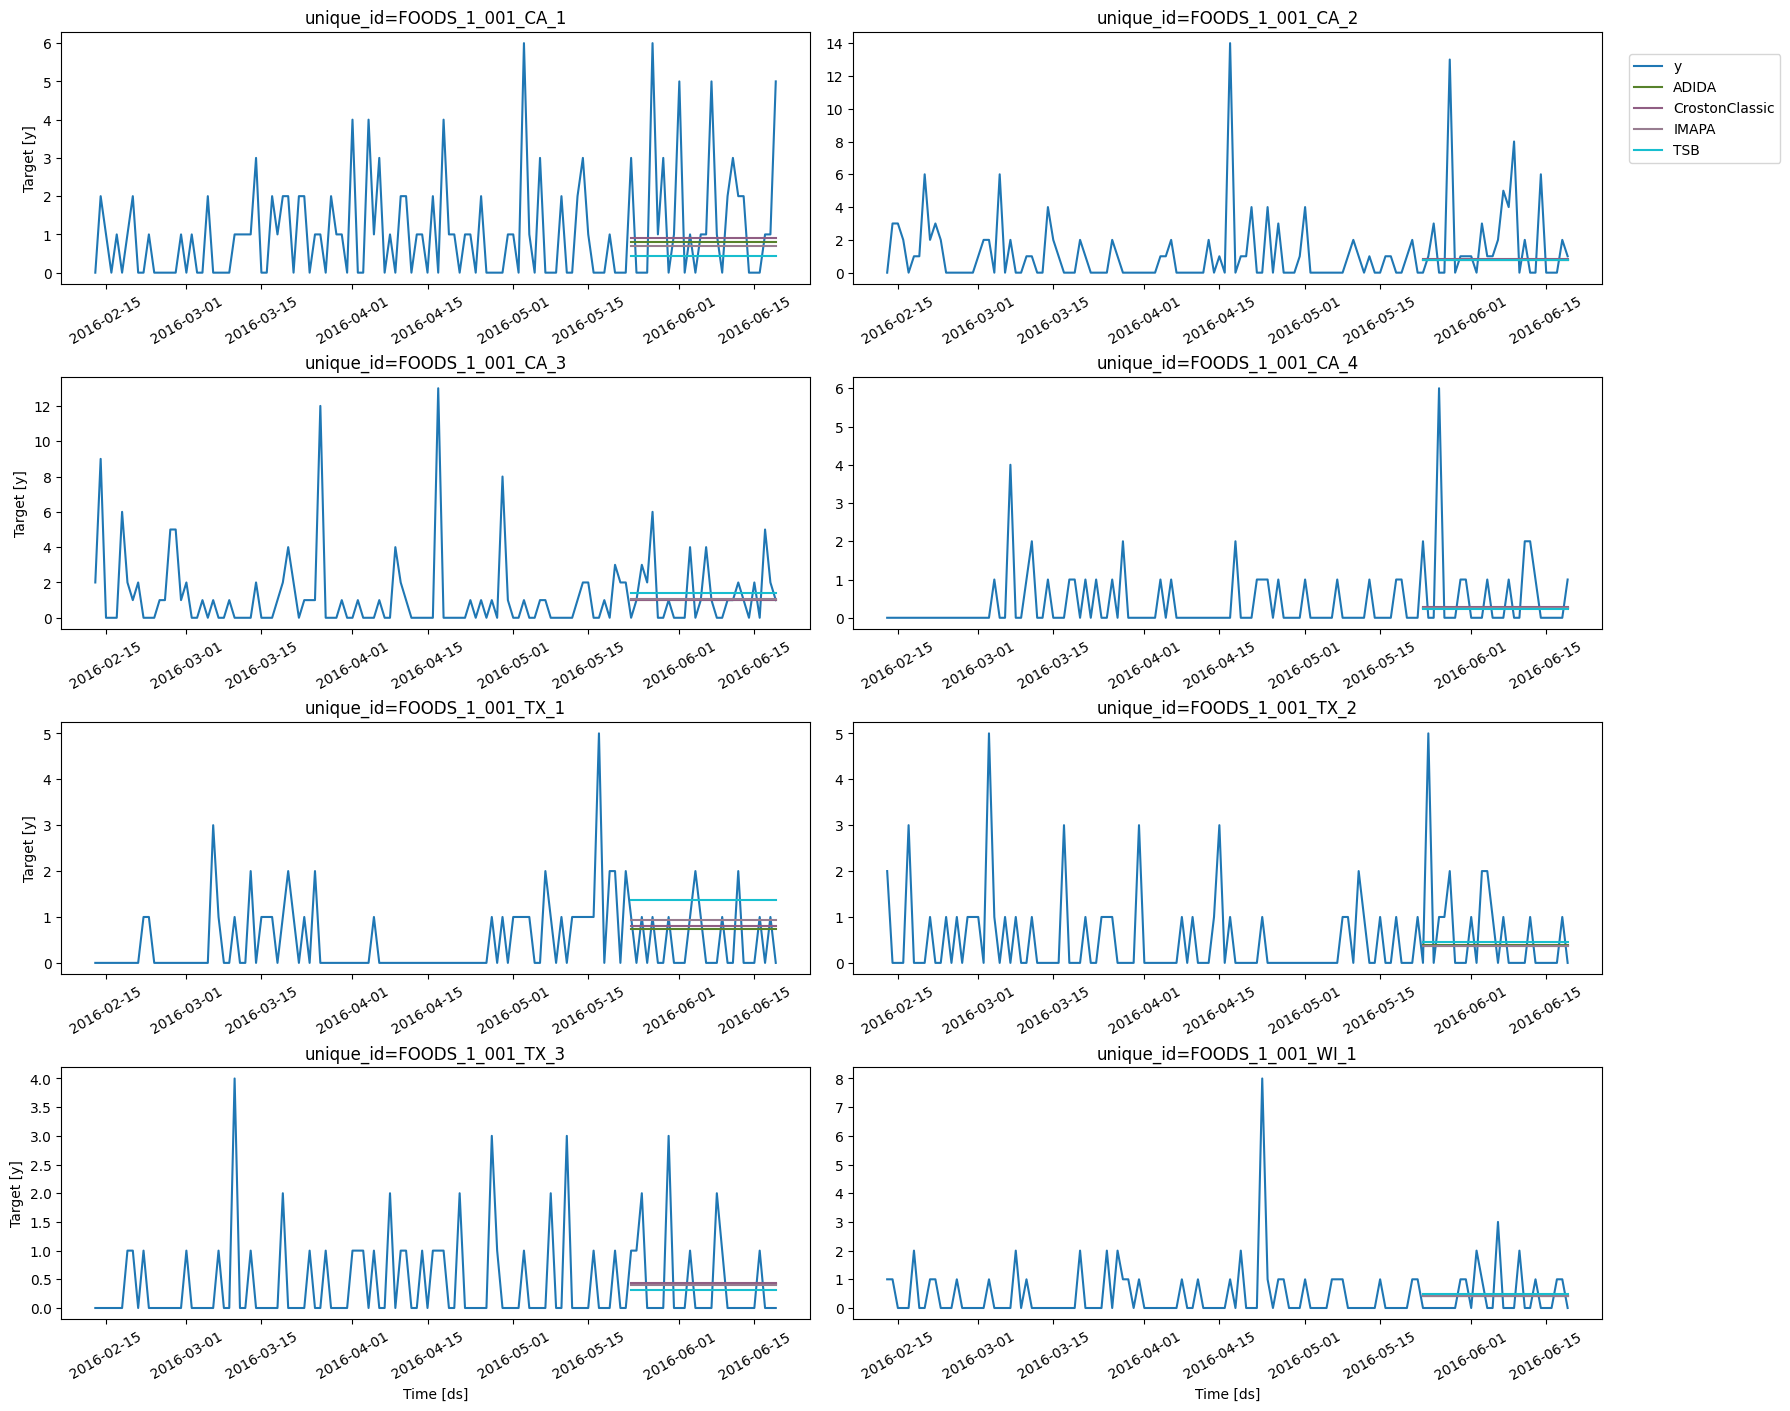

In [119]:
plot_series(train, test, plot_random=False, max_insample_length=100)

To compute the accuracy of the forecasts, we'll use the Mean Average Error (MAE), which is the sum of the absolute errors divided by the number of forecasts.

In [91]:
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae

In [120]:
evaluate(test, metrics = [mae], agg_fn = 'mean')

metric    ADIDA  CrostonClassic     IMAPA       TSB
0    mae  0.94873        0.944071  0.957257  1.023126

Hence, on average, the forecasts are one unit off.

---
---
---

In [5]:
# Ejemplos de uso:
loaded["df_ALL_LTS_m12"]       # acceso vía dict


unique_id         ds       y     client    dataset freq       global_id
0            103 2020-01-01  1440.0        AMC        Amc    m        Amc__103
1            103 2020-02-01  1728.0        AMC        Amc    m        Amc__103
2            103 2020-03-01   288.0        AMC        Amc    m        Amc__103
3            103 2020-04-01   864.0        AMC        Amc    m        Amc__103
4            103 2020-05-01   288.0        AMC        Amc    m        Amc__103
...          ...        ...     ...        ...        ...  ...             ...
136942       883 2025-04-01     0.0  Pescanova  Pescanova    m  Pescanova__883
136943       883 2025-05-01     0.0  Pescanova  Pescanova    m  Pescanova__883
136944       883 2025-06-01     0.0  Pescanova  Pescanova    m  Pescanova__883
136945       883 2025-07-01     0.0  Pescanova  Pescanova    m  Pescanova__883
136946       883 2025-08-01     0.0  Pescanova  Pescanova    m  Pescanova__883

[136947 rows x 7 columns]

In [1]:
# Instalar paquetes en el kernel actual del notebook
import sys
!{sys.executable} -m pip install -U nixtla utilsforecast

  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
Using cached httpx-0.28.1-py3-none-any.whl (73 kB)
Using cached httpcore-1.0.9-py3-none-any.whl (78 kB)
Using cached h11-0.16.0-py3-none-any.whl (37 kB)
Using cached sniffio-1.3.1-py3-none-any.whl (10 kB)

   ---- ----------------------------------- 1/9 [tenacity]
   ----------------- ---------------------- 4/9 [h11]
   ----------------- ---------------------- 4/9 [h11]
   ---------------------- ----------------- 5/9 [httpcore]
   -------------------------- ------------- 6/9 [anyio]
   -------------------------- ------------- 6/9 [anyio]
   ------------------------------- -------- 7/9 [httpx]
   ------------------------------- -------- 7/9 [httpx]
   ----------------------------------- ---- 8/9 [nixtla]
   --------------------------------


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
# PRUEBA
# Environment Setup
import time
import pandas as pd
import numpy as np

from nixtla import NixtlaClient
from utilsforecast.losses import mae
from utilsforecast.evaluation import evaluate

In [8]:
nixtla_client = NixtlaClient(api_key = 'nixak-vDWguUlBh5MiClqOSkUvVQhtbJPYi0p6yIPvjC2fqq6zTuk168fiFPp7CLfi5QCFv0xXkQYmbO5FlSqP')

## Cargar el dataset

In [13]:
# === Paso 1: Usar tu dataset en lugar del CSV de ejemplo ===
df = df_Noel_LTS_m12.copy()
# Frecuencia mensual (Month Start). Cambia a 'M'/'MS' si lo necesitas.
FREQ = 'MS'

In [14]:
# === Paso 2: Normalización mínima (ya vienes con unique_id, ds, y) ===
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df['y']  = pd.to_numeric(df['y'], errors='coerce')
df['unique_id'] = df['unique_id'].astype(str)
df = df.dropna(subset=['ds','y']).sort_values(['unique_id','ds']).reset_index(drop=True)

## Transformación Logarítmica

In [22]:
# # === Paso 3: Transformación logarítmica y split ===
# df_transformed = df.copy()
# df_transformed['y'] = np.log(df_transformed['y'] + 1)

# En el ejemplo original reservan 28 días. Aquí reservamos H meses.
H = 12  # horizonte mensual (ajusta a tu caso)
# test: últimos H puntos de cada serie; train: el resto
test_df  = df.groupby('unique_id', group_keys=False).tail(H)
input_df = df.drop(test_df.index).reset_index(drop=True)

# Asegurarnos de que cada serie tiene más de H observaciones
valid_ids = (
    df.groupby('unique_id')
    .size()
    .loc[lambda s: s > H]
    .index
)
input_df = input_df[input_df['unique_id'].isin(valid_ids)].reset_index(drop=True)
test_df  = test_df[test_df['unique_id'].isin(valid_ids)].reset_index(drop=True)

## Forecast con TimeGPT

In [24]:
# === Paso 4: Forecast con TimeGPT ===
start = time.time()
fcst_df = nixtla_client.forecast(
    df=input_df,
    h=H,
    level=[80],
    finetune_steps=10,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y',
    id_col='unique_id',
    freq=FREQ,              # mensual
)
timegpt_duration = time.time() - start
print(f"Time (TimeGPT): {timegpt_duration:.2f}s")

# # Invertir la transformación log en TODAS las columnas de predicción (incluye bandas)
# pred_cols = [c for c in fcst_df.columns if c not in ['unique_id','ds']]
# fcst_df[pred_cols] = np.exp(fcst_df[pred_cols]) - 1

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Time (TimeGPT): 2.29s


## Visualización y Evaluación (MAE)

In [25]:
# === Paso 5: Visualización y evaluación (MAE) ===
# OJO: test_df está en escala log; hay que volver a la escala original para evaluar correctamente
test_df_eval = test_df.copy()
test_df_eval['y'] = np.exp(test_df_eval['y']) - 1

# Gráfico (usa los datos reales en escala original)
nixtla_client.plot(
    test_df_eval,        # reales (escala original)
    fcst_df,             # predicciones
    models=['TimeGPT'],
    level=[80],
    time_col='ds',
    target_col='y'
)

from utilsforecast.losses import mae
from utilsforecast.evaluation import evaluate

# Unimos por llaves y calculamos métricas
merged = pd.merge(test_df_eval, fcst_df, how='left', on=['unique_id','ds'])
evaluation = evaluate(
    merged,
    metrics=[mae],
    models=['TimeGPT'],
    target_col='y',
    id_col='unique_id'
)
average_metrics = evaluation.groupby('metric')['TimeGPT'].mean().sort_index()
average_metrics

c:\Users\AlejandroLaderasImpe\Documents\InterForecast\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


metric
mae    inf
Name: TimeGPT, dtype: float64

## Comparación con Modelos Estadísticos

In [26]:
# pip install statsforecast  # si no lo tienes
from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic, CrostonOptimized, IMAPA, TSB

sf = StatsForecast(
    models=[CrostonClassic(), CrostonOptimized(), IMAPA(), TSB(alpha_d=0.1, alpha_p=0.1)],
    freq=FREQ,   # mensual
    n_jobs=-1
)

start_stats = time.time()
sf.fit(df=input_df[['unique_id','ds','y']])   # usa la serie transformada (log)
sf_preds = sf.predict(h=H)

stats_duration = time.time() - start_stats
print(f"Time (Statistical models): {stats_duration:.2f}s")

# Volver a escala original para comparar
sf_pred_cols = [c for c in sf_preds.columns if c not in ['unique_id','ds']]
sf_preds[sf_pred_cols] = np.exp(sf_preds[sf_pred_cols]) - 1

# Evaluar (ej. MAE promedio por modelo)
sf_merged = pd.merge(test_df_eval, sf_preds, on=['unique_id','ds'], how='left')
sf_eval = evaluate(
    sf_merged,
    metrics=[mae],
    models=sf_pred_cols,   # evalúa todos los modelos devueltos
    target_col='y',
    id_col='unique_id'
)
sf_eval.groupby('metric')[sf_pred_cols].mean().sort_index()


Time (Statistical models): 61.80s


c:\Users\AlejandroLaderasImpe\Documents\InterForecast\.venv\Lib\site-packages\pandas\core\internals\blocks.py:395: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


CrostonClassic  CrostonOptimized  IMAPA  TSB
metric                                              
mae                inf               inf    inf  inf

## Exógenas (a posteriori)

In [ ]:
# ejemplo de plantilla:
exog_cols = ['mi_exog1','mi_exog2']  # tus columnas
X_df = df[['unique_id','ds'] + exog_cols].copy()          # histórico
# añade aquí las filas futuras (H meses por serie) con valores conocidos:
# X_future = ...
# X_df = pd.concat([X_df, X_future], ignore_index=True)

fcst_df_ex = nixtla_client.forecast(
    df=input_df,
    X_df=X_df,
    h=H,
    level=[80],
    finetune_steps=10,
    finetune_loss='mae',
    model='timegpt-1-long-horizon',
    time_col='ds',
    target_col='y',
    id_col='unique_id',
    freq=FREQ,
)


## Representación

### A) Con la función de Nixtla

Dibuja reales vs TimeGPT

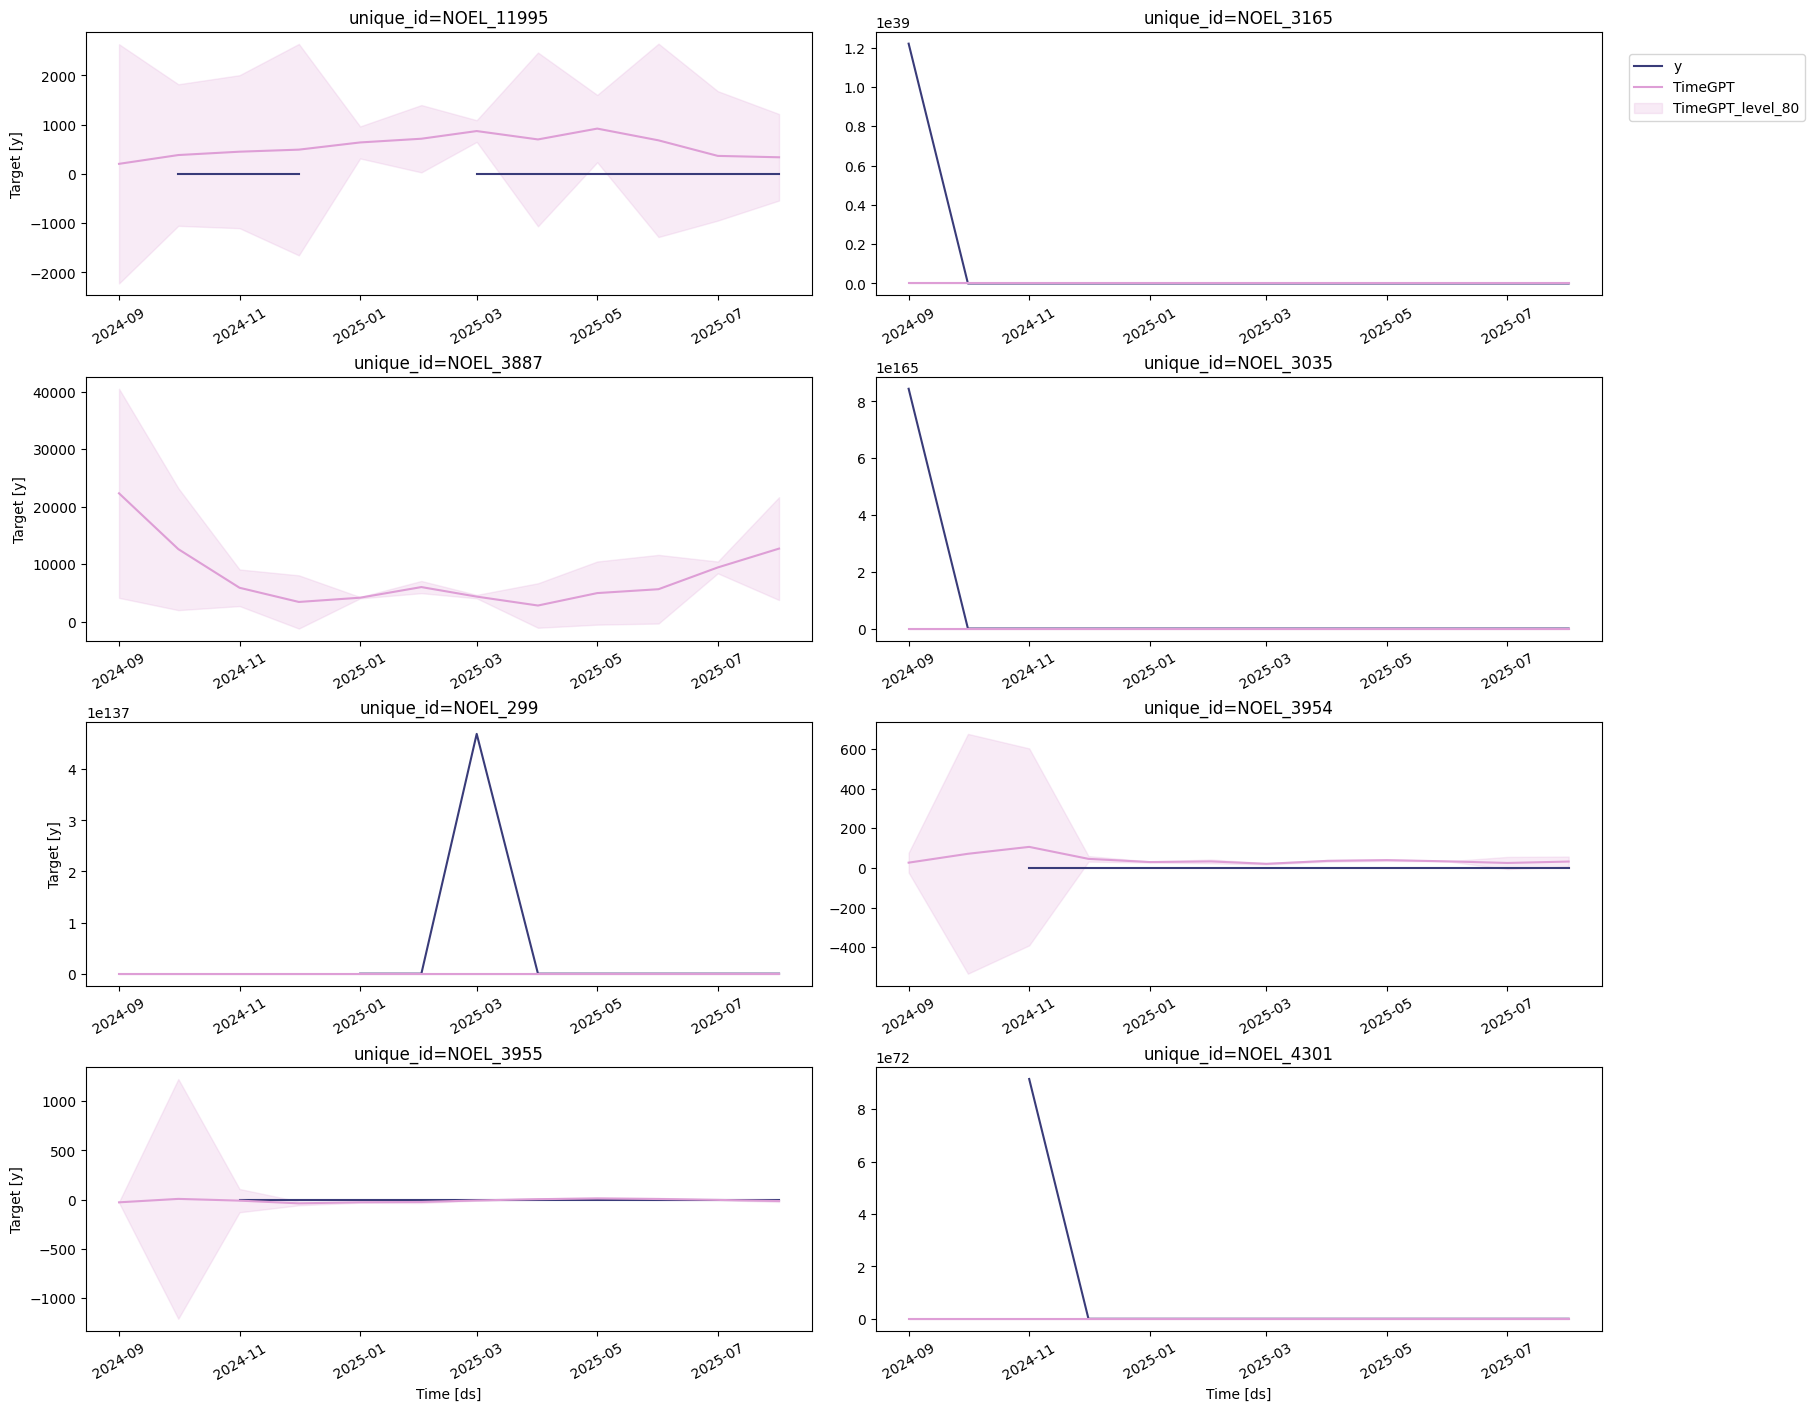

In [27]:
# Asegúrate de estar en escala original:
# test_df_eval['y'] ya está invertido (exp - 1) en tu código
nixtla_client.plot(
    test_df_eval,
    fcst_df,
    models=['TimeGPT'],  # nombre de la columna central en fcst_df
    level=[80],
    time_col='ds',
    target_col='y'
)


### B) Plot comparativo por serie (TimeGPT + Modelos Estadísticos)

Este bloque crea una función para una serie (unique_id) y sobrepone:

- Histórico + Test (escala original).
- Predicción TimeGPT (con banda 80%).
- Una predicción estadística (p. ej., TSB o la que se elija)

Usar después de calcular fcst_df (ya invertido) y sf_preds (ya invertido) como en el código.


c:\Users\AlejandroLaderasImpe\Documents\InterForecast\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


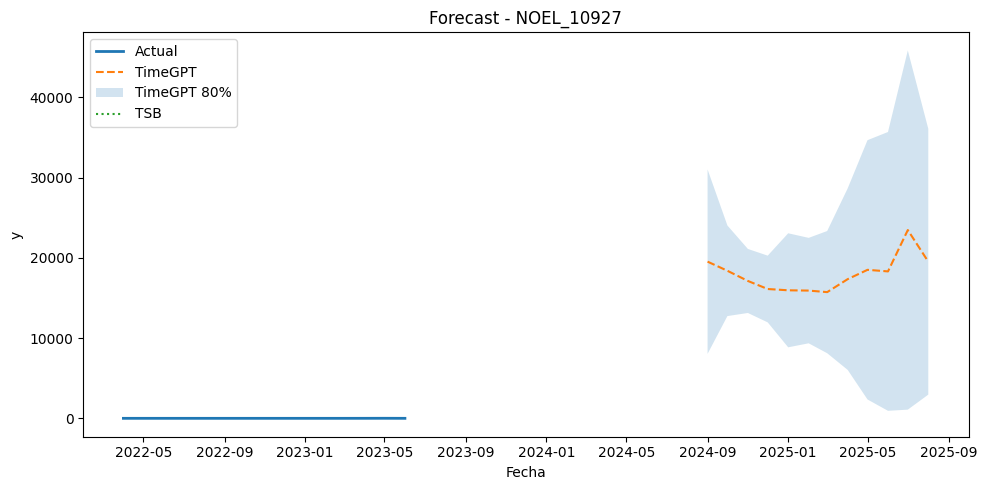

In [28]:
import matplotlib.pyplot as plt

# 1) Construimos "actuales" en escala original: train + test
Y_train_eval = input_df.copy()
Y_train_eval['y'] = np.exp(Y_train_eval['y']) - 1  # invertimos log(+1)
actual_df = (
    pd.concat([Y_train_eval[['unique_id','ds','y']], test_df_eval[['unique_id','ds','y']]])
      .sort_values(['unique_id','ds'])
      .reset_index(drop=True)
)

# 2) Detectamos nombres de columnas de modelos en fcst_df (TimeGPT) e intervalos
fcst_models = [c for c in fcst_df.columns if c not in ['unique_id','ds'] and ('-lo-' not in c and '-hi-' not in c)]
timegpt_model = 'TimeGPT' if 'TimeGPT' in fcst_models else (fcst_models[0] if fcst_models else None)

def get_interval_cols(df, model_name, level=80):
    lo = f"{model_name}-lo-{level}"
    hi = f"{model_name}-hi-{level}"
    lo_col = lo if lo in df.columns else None
    hi_col = hi if hi in df.columns else None
    return lo_col, hi_col

timegpt_lo, timegpt_hi = (get_interval_cols(fcst_df, timegpt_model, 80) if timegpt_model else (None, None))

# 3) Detectamos qué modelos estadísticos devolverion columnas (Croston, IMAPA, TSB, etc.)
sf_model_cols = [c for c in sf_preds.columns if c not in ['unique_id','ds']]
sf_default = 'TSB' if 'TSB' in sf_model_cols else (sf_model_cols[0] if sf_model_cols else None)

def plot_forecast(unique_id, stat_model=sf_default):
    """Dibuja Histórico/Test + TimeGPT (+ banda 80%) + un modelo estadístico."""
    if timegpt_model is None:
        raise RuntimeError("No encuentro columnas de predicción de TimeGPT en fcst_df.")
    if stat_model and stat_model not in sf_model_cols:
        raise ValueError(f"'{stat_model}' no está en sf_preds. Disponibles: {sf_model_cols}")

    # Filtrar por serie
    hist = actual_df[actual_df['unique_id'] == unique_id].sort_values('ds')
    tgpt = fcst_df[fcst_df['unique_id'] == unique_id].sort_values('ds')
    stat = sf_preds[sf_preds['unique_id'] == unique_id].sort_values('ds') if stat_model else None

    plt.figure(figsize=(10, 5))

    # Histórico/Test
    plt.plot(hist['ds'], hist['y'], label='Actual', linewidth=2)

    # TimeGPT central
    plt.plot(tgpt['ds'], tgpt[timegpt_model], label=f'{timegpt_model}', linestyle='--')

    # Banda de confianza 80% (si existe)
    if timegpt_lo and timegpt_hi and timegpt_lo in tgpt.columns and timegpt_hi in tgpt.columns:
        plt.fill_between(tgpt['ds'], tgpt[timegpt_lo], tgpt[timegpt_hi], alpha=0.2, label='TimeGPT 80%')

    # Modelo estadístico (opcional)
    if stat_model:
        plt.plot(stat['ds'], stat[stat_model], label=stat_model, linestyle=':')

    plt.title(f'Forecast - {unique_id}')
    plt.xlabel('Fecha')
    plt.ylabel('y')
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Ejemplos de uso ===
# 1) Ver el primer unique_id disponible
uid0 = actual_df['unique_id'].iloc[0]
plot_forecast(uid0)              # TimeGPT + TSB (si existe TSB)

# 2) Elegir un unique_id concreto y comparar con IMAPA
# plot_forecast('MI_SERIE', stat_model='IMAPA')


---

# OTRA PRUEBA

Pipeline vecotrizado que calcula para todas las series del df_Noel_LTS_m12:

- split por serie (últimos H meses a test)
- forecast con TimeGPT (todas las series a la vez)
- comparación con StatsForecast (Croston/IMAPA/TSB)
- evaluación MAE por serie y agregado
- guardado de gráficas por serie (opcional)

Ajusta H y FREQ si lo necesitas.

In [ ]:
import os, time, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# ======================
# Config
# ======================
H = 3                    # horizonte mensual
FREQ = 'MS'               # mensual (Month Start)
OUTPUT_DIR = "forecasts_charts"  # carpeta para PNGs por serie
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ======================
# 0) Base: usar tu DF
# ======================
df = df_Frias_STS_m6.copy()
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df['y']  = pd.to_numeric(df['y'], errors='coerce')
df['unique_id'] = df['unique_id'].astype(str)
df = df.dropna(subset=['ds','y']).sort_values(['unique_id','ds']).reset_index(drop=True)

# # filtra series con historial suficiente
# counts = df.groupby('unique_id').size()
# valid_ids = counts[counts > H].index
# df = df[df['unique_id'].isin(valid_ids)].reset_index(drop=True)

# >>> NUEVO: exigir mínimo para finetune (25) + horizonte (H)
REQUIRED_TRAIN = 15
min_total_obs = REQUIRED_TRAIN + H
counts = df.groupby('unique_id').size()
valid_ids = counts[counts >= min_total_obs].index
dropped = counts[counts < min_total_obs]
if len(dropped):
    print(f"Descartadas {len(dropped)} series por historial insuficiente (< {min_total_obs}).")
df = df[df['unique_id'].isin(valid_ids)].reset_index(drop=True)

# ======================
# 1) Transformación + split (para TODAS las series)
# ======================
df_t = df.copy()
df_t['y'] = np.log(df_t['y'] + 1)

# test = últimos H por serie, train = resto
test_df  = df_t.groupby('unique_id', group_keys=False).tail(H)
input_df = df_t.drop(test_df.index).reset_index(drop=True)

# para evaluar en escala original:
test_df_eval = test_df.copy()
test_df_eval['y'] = np.exp(test_df_eval['y']) - 1

# ======================
# 2) Forecast con TimeGPT (todas las series)
# ======================
from nixtla import NixtlaClient
# nixtla_client = NixtlaClient()  # ya creado antes; si no, descomenta

start = time.time()
fcst_df = nixtla_client.forecast(
    df=input_df,
    h=H,
    level=[80],
    finetune_steps=1,
    finetune_loss='mae',
    model='timegpt-1',
    time_col='ds',
    target_col='y',
    id_col='unique_id',
    freq=FREQ,
)
print(f"Time (TimeGPT): {time.time() - start:.2f}s")

# volver a escala original
pred_cols_tgpt = [c for c in fcst_df.columns if c not in ['unique_id','ds']]
fcst_df[pred_cols_tgpt] = np.exp(fcst_df[pred_cols_tgpt]) - 1

# ======================
# 3) Forecast con modelos estadísticos (todas las series)
# ======================
from statsforecast import StatsForecast
from statsforecast.models import CrostonClassic, CrostonOptimized, IMAPA, TSB

stat_models = [CrostonClassic(), CrostonOptimized(), IMAPA(), TSB(alpha_d=0.5, alpha_p=0.5)]

sf = StatsForecast(models=stat_models, freq=FREQ, n_jobs=-1)

start = time.time()
sf.fit(df=input_df[['unique_id','ds','y']])     # en log(+1)
sf_preds = sf.predict(h=H)                      # devuelve columnas por modelo
print(f"Time (Statistical models): {time.time() - start:.2f}s")

# volver a escala original
pred_cols_stat = [c for c in sf_preds.columns if c not in ['unique_id','ds']]
sf_preds[pred_cols_stat] = np.exp(sf_preds[pred_cols_stat]) - 1

# ======================
# 4) Evaluación para TODAS las series
# ======================
from utilsforecast.losses import mae
from utilsforecast.evaluation import evaluate

# === Unir reales (test) + TODAS las predicciones en un SOLO df ===
preds_all = pd.merge(fcst_df, sf_preds, on=['unique_id','ds'], how='outer')

merged = pd.merge(
    test_df_eval,           # y reales en escala original
    preds_all,              # todas las predicciones
    on=['unique_id','ds'],
    how='left'
)

# Solo columnas "centrales" de modelos (sin intervalos -lo-/-hi-)
model_cols = [
    c for c in merged.columns
    if c not in ['unique_id','ds','y'] and '-lo-' not in c and '-hi-' not in c
]

# === Evaluación correcta ===
eval_df = evaluate(
    merged,                 # << un SOLO DataFrame
    metrics=[mae],
    models=model_cols,
    target_col='y',
    id_col='unique_id'
)

# MAE promedio por modelo (agregado)
avg_mae = (
    eval_df.groupby('metric')[model_cols]
    .mean()
    .T.reset_index()
    .rename(columns={'index': 'model'})
    .sort_values('mae')
)
print("== MAE promedio por modelo ==")
print(avg_mae)

# MAE por serie y “ganador”
mae_by_series = (
    eval_df.loc[eval_df['metric'] == 'mae', ['unique_id'] + model_cols]
    .reset_index(drop=True)
)
mae_by_series['best_model'] = mae_by_series[model_cols].idxmin(axis=1)

print("\n== Ganadores por serie (conteo) ==")
print(mae_by_series['best_model'].value_counts())


# ARREGLO MÍNIMO
###################
# Lista de modelos estadísticos (todo lo que no sea TimeGPT)
stat_only = [m for m in model_cols if m != 'TimeGPT']

# Mejor modelo estadístico por serie (además del best_model global que ya calculaste)
if stat_only:
    mae_by_series['best_stat_model'] = mae_by_series[stat_only].idxmin(axis=1)
else:
    mae_by_series['best_stat_model'] = None
###################


# ======================
# 5) Guardar gráficas por serie (opcional)
# ======================
# Histórico + test en escala original
Y_train_eval = input_df.copy()
Y_train_eval['y'] = np.exp(Y_train_eval['y']) - 1
actual_df = (
    pd.concat([Y_train_eval[['unique_id','ds','y']], test_df_eval[['unique_id','ds','y']]])
      .sort_values(['unique_id','ds'])
      .reset_index(drop=True)
)

def get_interval_cols(df, model_name, level=80):
    lo = f"{model_name}-lo-{level}"
    hi = f"{model_name}-hi-{level}"
    lo_col = lo if lo in df.columns else None
    hi_col = hi if hi in df.columns else None
    return lo_col, hi_col

timegpt_model = 'TimeGPT' if 'TimeGPT' in model_cols else None
t_lo, t_hi = (get_interval_cols(fcst_df, timegpt_model, 80) if timegpt_model else (None, None))

# para cada serie, guardamos PNG con: Actual + TimeGPT + mejor estadístico de esa serie
for uid, g in actual_df.groupby('unique_id'):
    hist = g.sort_values('ds')
    tgpt = fcst_df[fcst_df['unique_id']==uid].sort_values('ds')
    stat = sf_preds[sf_preds['unique_id']==uid].sort_values('ds') if len(pred_cols_stat) else None

    # mejor estadístico para esta serie
    best_stat_model = None
    if stat_only:
        row = mae_by_series.loc[mae_by_series['unique_id']==uid]
        if not row.empty:
            best_stat_model = row['best_stat_model'].iloc[0]

    plt.figure(figsize=(10, 5))
    # Actual
    plt.plot(hist['ds'], hist['y'], label='Actual', linewidth=2)

    # TimeGPT
    if timegpt_model is not None and timegpt_model in tgpt.columns:
        plt.plot(tgpt['ds'], tgpt[timegpt_model], label='TimeGPT', linestyle='--')
        if t_lo and t_hi and t_lo in tgpt.columns and t_hi in tgpt.columns:
            plt.fill_between(tgpt['ds'], tgpt[t_lo], tgpt[t_hi], alpha=0.2, label='TimeGPT 80%')

    # Mejor estadístico
    if best_stat_model and best_stat_model in stat.columns:
        plt.plot(stat['ds'], stat[best_stat_model], label=best_stat_model, linestyle=':')

    plt.title(f'Forecast - {uid}')
    plt.xlabel('Fecha'); plt.ylabel('y')
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{uid}.png"), dpi=150)
    plt.close()

print(f"Gráficas guardadas en: {os.path.abspath(OUTPUT_DIR)}")

# ======================
# 6) (Opcional) Exportar métricas a CSV
# ======================
avg_mae.to_csv("avg_mae_overall.csv", index=False)
mae_by_series.to_csv("mae_by_series.csv", index=False)
print("Métricas exportadas: avg_mae_overall.csv, mae_by_series.csv")


NameError: name 'nixtla_client' is not defined

Qué hace?

- Calcula todo para todas las series de df_Noel_LTS_m12 en bloque (sin bucles ineficientes).
- Deja dos tablas:
     - avg_mae -> MAE medio por modelo (global)
     - mae_by_series -> MAE por serie y modelo (+ columna best_model)
- Guarda una imagen por serie en forecast_charts/ con: Real vs TimeGPT (+ banda 80%) vs mejor estadístico para esa serie.

In [13]:
import os, time, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# ======================
# Config
# ======================
H = 12                     # horizonte mensual
FREQ = 'MS'               # mensual (Month Start)
SEASON = 12               # estacionalidad mensual típica
MIN_TRAIN = 24            # mínimo de pasos de TRAIN que quieres exigir
LAGS = [1, 2, 3, 6, 12]   # lags para MLForecast (asegúrate de que MIN_TRAIN >= max(LAGS))
OUTPUT_DIR = "forecasts_charts_m6"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ======================
# 0) Base: usar tu DF
# ======================
df = df_Pescanova_STS_m12.copy()
df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
df['y']  = pd.to_numeric(df['y'], errors='coerce')
df['unique_id'] = df['unique_id'].astype(str)
df = df.dropna(subset=['ds','y']).sort_values(['unique_id','ds']).reset_index(drop=True)

# exigir mínimo total = TRAIN mínimo + horizonte
min_total_obs = max(MIN_TRAIN, max(LAGS)) + H  # garantizamos que haya lags y test
counts = df.groupby('unique_id').size()
valid_ids = counts[counts >= min_total_obs].index
dropped = counts[counts < min_total_obs]
if len(dropped):
    print(f"Descartadas {len(dropped)} series por historial insuficiente (< {min_total_obs}).")
df = df[df['unique_id'].isin(valid_ids)].reset_index(drop=True)

# ======================
# 1) Transformación + split (para TODAS las series)
# ======================
df_t = df.copy()
df_t['y'] = np.log(df_t['y'] + 1)

# test = últimos H por serie, train = resto
test_df  = df_t.groupby('unique_id', group_keys=False).tail(H)
input_df = df_t.drop(test_df.index).reset_index(drop=True)

# para evaluar en escala original:
test_df_eval = test_df.copy()
test_df_eval['y'] = np.exp(test_df_eval['y']) - 1

# ======================
# 2) Forecast con TimeGPT (zero-shot, sin fine-tune)
# ======================
from nixtla import NixtlaClient
# nixtla_client = NixtlaClient()  # si no lo tienes creado arriba

start = time.time()
fcst_df = nixtla_client.forecast(
    df=input_df,
    h=H,
    level=[80],
    finetune_steps=1,                 # << desactiva fine-tune para no exigir 25 puntos de train
    finetune_loss='mae',
    model='timegpt-1',   # puedes usar 'timegpt-1' si prefieres
    time_col='ds',
    target_col='y',
    id_col='unique_id',
    freq=FREQ,
)
print(f"Time (TimeGPT): {time.time() - start:.2f}s")

# volver a escala original
pred_cols_tgpt = [c for c in fcst_df.columns if c not in ['unique_id','ds']]
fcst_df[pred_cols_tgpt] = np.exp(fcst_df[pred_cols_tgpt]) - 1

# ======================
# 3) Modelos estadísticos adicionales (ARIMA, ETS) + (opcional) otros
# ======================
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, SeasonalNaive, CrostonClassic, CrostonOptimized, IMAPA, TSB

stat_models = [
    AutoARIMA(season_length=SEASON),   # ARIMA automático estacional
    AutoETS(season_length=SEASON),         # ETS (auto-estructura por defecto)
    SeasonalNaive(season_length=SEASON),
    # Los de intermitentes no son ideales para series smooth, pero puedes dejarlos si quieres comparar:
    # CrostonClassic(), CrostonOptimized(), IMAPA(), TSB(alpha_d=0.1, alpha_p=0.1)
]

sf = StatsForecast(models=stat_models, freq=FREQ, n_jobs=-1)

start = time.time()
sf.fit(df=input_df[['unique_id','ds','y']])     # ojo: seguimos en log(+1)
sf_preds = sf.predict(h=H)                      # columnas con nombres de cada modelo
print(f"Time (Statistical models): {time.time() - start:.2f}s")

# volver a escala original
pred_cols_stat = [c for c in sf_preds.columns if c not in ['unique_id','ds']]
sf_preds[pred_cols_stat] = np.exp(sf_preds[pred_cols_stat]) - 1

# ======================
# 4) MLForecast + LightGBM (aprendizaje automático)
# ======================
from mlforecast import MLForecast
from lightgbm import LGBMRegressor

mlf = MLForecast(
    models=[LGBMRegressor(
        n_estimators=500, learning_rate=0.05, subsample=0.9, colsample_bytree=0.9,
        random_state=42
    )],
    freq=FREQ,
    lags=LAGS,              # solo lags; puedes añadir rolling stats si quieres
)
# Fit en log(+1)
mlf.fit(
    input_df[['unique_id','ds','y']],
    id_col='unique_id', time_col='ds', target_col='y'
)
mlf_preds = mlf.predict(h=H)   # columnas: 'unique_id','ds','LGBMRegressor'

# volver a escala original
mlf_pred_cols = [c for c in mlf_preds.columns if c not in ['unique_id','ds']]
mlf_preds[mlf_pred_cols] = np.exp(mlf_preds[mlf_pred_cols]) - 1

# ======================
# 5) Evaluación para TODAS las series
# ======================
from utilsforecast.losses import mae
from utilsforecast.evaluation import evaluate

# Unimos todas las predicciones
preds_all = sf_preds.merge(fcst_df, on=['unique_id','ds'], how='outer')\
                    .merge(mlf_preds, on=['unique_id','ds'], how='outer')

merged = pd.merge(
    test_df_eval,           # y reales (escala original)
    preds_all,              # todas las predicciones
    on=['unique_id','ds'],
    how='left'
)

# columnas "centrales" de modelo (sin intervalos -lo-/-hi-)
model_cols = [
    c for c in merged.columns
    if c not in ['unique_id','ds','y'] and '-lo-' not in c and '-hi-' not in c
]

eval_df = evaluate(
    merged,
    metrics=[mae],
    models=model_cols,
    target_col='y',
    id_col='unique_id'
)

# MAE promedio por modelo
avg_mae = (
    eval_df.groupby('metric')[model_cols]
    .mean()
    .T.reset_index().rename(columns={'index':'model'})
    .sort_values('mae')
)
print("== MAE promedio por modelo ==")
print(avg_mae)

# MAE por serie + ganador
mae_by_series = (
    eval_df.loc[eval_df['metric']=='mae', ['unique_id'] + model_cols]
    .reset_index(drop=True)
)
mae_by_series['best_model'] = mae_by_series[model_cols].idxmin(axis=1)

# “mejor estadístico” (todo menos TimeGPT y LGBM)
stat_comp = [m for m in model_cols if m not in ['TimeGPT','LGBMRegressor']]
mae_by_series['best_stat_model'] = mae_by_series[stat_comp].idxmin(axis=1) if stat_comp else None

print("\n== Ganadores por serie (conteo) ==")
print(mae_by_series['best_model'].value_counts())

# ======================
# 6) Gráficas por serie (Actual vs TimeGPT vs mejor estadístico vs LGBM)
# ======================
Y_train_eval = input_df.copy()
Y_train_eval['y'] = np.exp(Y_train_eval['y']) - 1
actual_df = (
    pd.concat([Y_train_eval[['unique_id','ds','y']], test_df_eval[['unique_id','ds','y']]])
      .sort_values(['unique_id','ds'])
      .reset_index(drop=True)
)

def get_interval_cols(df, model_name, level=80):
    if model_name is None:
        return None, None
    lo, hi = f"{model_name}-lo-{level}", f"{model_name}-hi-{level}"
    return (lo if lo in df.columns else None), (hi if hi in df.columns else None)

timegpt_model = 'TimeGPT' if 'TimeGPT' in model_cols else None
t_lo, t_hi = get_interval_cols(fcst_df, timegpt_model, 80)

for uid, g in actual_df.groupby('unique_id'):
    hist = g.sort_values('ds')
    tgpt = fcst_df[fcst_df['unique_id']==uid].sort_values('ds')
    stts = preds_all[preds_all['unique_id']==uid].sort_values('ds')
    best_stat = mae_by_series.loc[mae_by_series['unique_id']==uid, 'best_stat_model'].iloc[0] if stat_comp else None

    plt.figure(figsize=(10,5))
    plt.plot(hist['ds'], hist['y'], label='Actual', linewidth=2)

    # TimeGPT
    if timegpt_model and timegpt_model in tgpt.columns:
        plt.plot(tgpt['ds'], tgpt[timegpt_model], label='TimeGPT', linestyle='--')
        if t_lo and t_hi and t_lo in tgpt.columns and t_hi in tgpt.columns:
            plt.fill_between(tgpt['ds'], tgpt[t_lo], tgpt[t_hi], alpha=0.2, label='TimeGPT 80%')

    # LGBM
    if 'LGBMRegressor' in stts.columns:
        plt.plot(stts['ds'], stts['LGBMRegressor'], label='LGBM', linestyle='-.')

    # Mejor estadístico
    if best_stat and best_stat in stts.columns:
        plt.plot(stts['ds'], stts[best_stat], label=best_stat, linestyle=':')

    plt.title(f'Forecast (H={H}) - {uid}')
    plt.xlabel('Fecha'); plt.ylabel('y')
    plt.legend(); plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"{uid}.png"), dpi=150)
    plt.close()

print(f"Gráficas guardadas en: {os.path.abspath(OUTPUT_DIR)}")

# ======================
# 7) Exportar métricas a CSV
# ======================
avg_mae.to_csv("avg_mae_overall.csv", index=False)
mae_by_series.to_csv("mae_by_series.csv", index=False)
print("Métricas exportadas: avg_mae_overall.csv, mae_by_series.csv")


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Time (TimeGPT): 8.57s
Time (Statistical models): 64.04s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 6845, number of used features: 5
[LightGBM] [Info] Start training from score 7,938221
== MAE promedio por modelo ==
metric          model          mae
1             AutoETS  4521.612010
4       LGBMRegressor  4729.286652
0           AutoARIMA  4887.657120
2       SeasonalNaive  5206.893430
3             TimeGPT  5390.575060

== Ganadores por serie (conteo) ==
best_model
LGBMRegressor    83
TimeGPT          80
AutoARIMA        74
AutoETS          69
SeasonalNaive    46
Name: count, dtype: int64
Gráficas guardadas en: c:\Projects\MLForecast\scripts\forecasts_charts_m6
Métricas exportadas: avg_mae_overall.csv, mae_by_series.csv
